 # Analysis and predictive modelling of prevalence of cardiovascular diseases in U.S. states using machine learning

Igor Putrenko

Capstone project for Springboard Data Science Intensive workshop 

  **Problem:**
  
  Cardiovascular diseases (CVD) are estimated to be the leading cause of death and disability-adjusted life years lost worldwide.(1) According to the World Health Organization global estimates of mortality and burden of disease, around 17.3 million people died from CVD in 2008 representing 30% of all global deaths. (2,3) As estimated, one in three U.S. adults (about 71.3 million) has one or more types of CVD. By 2030, annual direct medical costs associated with CVD are projected to rise to more than 818 billion dollars, while lost productivity costs could exceed 275 billion dollars.(4) Reducing CVD-associated medical costs would substantially decrease the economic burden on the healthcare system.
  
  The underlying cause of CVD is atherosclerosis, a process mainly governed by lifestyle factors (risk factors). The prevalence of CVD increases with advancing age and varies within racial, ethnic, geographic, and sociodemographic groups. Identification of such global risk factors has led to the development of risk-prediction algorithms and cardiovascular risk models for men and women. However, they cannot fully explain the excess cardiovascular risk, and at least 25% of all future events occur in individuals with only one of the classical risk factors. Moreover, the prevalence of risk factors is almost as high in individuals without the disease as in patients affected by it. Socioeconomic inequalities also have been associated with greater subsequent socioeconomic differences in cardiovascular disease. Within high-income countries, low income and low educational status are consistently associated with greater risk of cardiovascular disease.

  **References:**
1. G Vilahur et all (2014) Perspectives: The burden of cardiovascular risk factors and coronary heart disease in Europe and worldwide. Eur Heart J Suppl (2014) 16
2. R Lozano et all (2010) Lancet, 2012, vol. 380(pg. 2095-2128)
3. Global Status Report on Noncommunicable Diseases, 2010 Geneva World Health Organization
4. http://www.cdcfoundation.org/pr/2015/heart-disease-and-stroke-cost-america-nearly-1-billion-day-medical-costs-lost-productivity


**Questions:**

- Is there a correlation between the prevalence of risk factors (obesity, physical inactivity, cholesterol level, hypertension, smoking, and diabetes) and CVD (CHD, stroke, and heart attack)?
- Is there any correlation between the prevalence of risk factors and CVD in different states and their socioeconomic characteristics (education, GDP, household income, and healthcare spending) and geographic factors (climate and location)?
- What is the rank of the prevalence of risk factors and CVD for different break out groups (age: 25-44, 45-64, 65+; gender: male and female; race/ethnicity: non-Hispanic White, non-Hispanic Black, Hispanic)?
- What factors/characteristics contribute most to the prevalence of CVD?
- Can the prevalence of CVD be modelled and predicted?


**Proposed Clients:**

  *U.S. federal and state health agencies*: Healthcare spending in U.S. is characterized as the most costly compared to all developed countries. The Centers for Medicare and Medicaid reported in 2014 that U.S. healthcare costs were 17.4% GDP in 2013. Therefore, the economic effect of accurate budget planning and optimization of healthcare spending is hard to overestimate. In addition, increased adherence to clinical and community-level guidelines as well as renewed emphasis on policy, environmental, and lifestyle changes will be crucial for effective prevention and control of CVD.
  
  *Insurance companies*: Premium rates for policyholders are calculated with the help of risk assessment, which are based on an individual’s key indicators. However, the merits of the numerous composite risk scores currently used for estimating an individual's future risk of CVD has been debated. Correct risk assessment could save millions of dollars for insurance companies.


**Data:**

[Prevalence of traditional risk factors and CVD among U.S. population (state, gender, race, age group, and geolocation for 2011-2014)](https://catalog.data.gov/dataset/behavioral-risk-factor-data-heart-disease-amp-stroke-prevention)

[Health spending - U.S. states](http://kff.org/other/state-indicator/health-spending-per-capita-by-service/?currentTimeframe=0&selectedRows=%7B%7D)

[Education - U.S. states](https://en.wikipedia.org/wiki/List_of_U.S._states_by_educational_attainment)

[GDP per capita - U.S.states](https://en.wikipedia.org/wiki/List_of_U.S._states_by_GDP_per_capita)

[Average annual temperature - U.S. states](https://www.currentresults.com/Weather/US/average-annual-state-temperatures.php)


## Data wrangling

In [1]:
## Importing modules and setting environment
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import seaborn as sns
sns.set_context(rc={"figure.figsize": (6,3)})
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import sklearn
import inspect
import numpy as np
import os

os.chdir(r'C:\Users\Igor\Jupyter_Notebook_Projects\Capstone project')

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [2]:
# Importing CVD and RF data into a dataframe
df = pd.DataFrame.from_csv('Risk_Factors_CVD.csv', index_col=None)
df.head(3)

,Year,LocationAbbr,LocationDesc,Datasource,PriorityArea1,PriorityArea2,PriorityArea3,PriorityArea4,Category,Topic,...,Data_Value_Footnote,Confidence_Limit_Low,Confidence_Limit_High,CategoryID,TopicID,IndicatorID,BreakoutCategoryID,BreakOutID,LocationID,GeoLocation
0,2011,NV,Nevada,BRFSS,None,None,None,None,Cardiovascular Diseases,Coronary Heart Disease,...,Statistically unstable estimates not presented...,NaN,NaN,C1,T4,BR001,BOC03,AGE04,32.0,"(39.493240390000494, -117.07184056399967)"
1,2011,NV,Nevada,BRFSS,None,None,None,None,Cardiovascular Diseases,Coronary Heart Disease,...,Statistically unstable estimates not presented...,NaN,NaN,C1,T4,BR001,BOC04,RAC02,32.0,"(39.493240390000494, -117.07184056399967)"
2,2011,NV,Nevada,BRFSS,None,None,None,None,Cardiovascular Diseases,Coronary Heart Disease,...,Statistically unstable estimates not presented...,NaN,NaN,C1,T4,BR001,BOC03,AGE01,32.0,"(39.493240390000494, -117.07184056399967)"


In [3]:
## Cleaning data:
# Removing repetitive age categories as well as 18-24 group (null values for many factors)
# Removing 'Nutrition' topic (controversial)
# Removing 'Overall' break out and average US LocationID rows
# Selecting year - 2013 data set is most informative
# Removing Washington, DC (outlier, not a good representation)
# Removing 'Non-Hispanic Asian' group (not complete)
a = df.Break_out != '35+'
b = df.Break_out != '75+'
c = df.Break_out != '20-24'
d = df.Break_out != '18-24'
e = df.Break_out != 'Overall'
f = df.Break_out != 'Non-Hispanic Asian'
g = df.LocationAbbr != 'DC'
h = df.Year == 2013
i = df.LocationID != 0.5
j = df.Topic != 'Nutrition'

df1 = df[(a) & (b) & (c) & (d) & (e) & (f) & (g) & (h) & (i) & (j)] # creating a new df1

In [4]:
## Cleaning data:
# Removing repetitive indicators and creating new df2
list = ('post-hospitalization', 'Objective 6', 'Objective 7', 'screening', 'Objective 5', 'Objective 11', 'hypertension medication', 'Objective 8', 'Objective 9')

df2 = df1[~df.Indicator.str.contains('|'.join(list))]

C:\Users\Igor\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [5]:
## Cleaning data:
# Removing rows with null prevalence values and creating new df3
df3 = df2.dropna(subset=['Data_Value'])

In [6]:
# Renaming a few topics
df3 = df3.replace('Acute Myocardial Infarction (Heart Attack)', 'Heart_attack')
df3 = df3.replace('Coronary Heart Disease', 'CHD')
df3 = df3.replace('Physical Inactivity', 'Phys_inact')
df3 = df3.replace('Cholesterol Abnormalities', 'Cholesterol')

In [7]:
# Comparing the number of rows in dataframes after cleaning
print(len(df))
print(len(df1))
print(len(df2))
print(len(df3))

35004
7970
4050
3533


In [8]:
# Importing US states socioeconomic data (excluding Washingon, DC) from a csv file to a dataframe
df_us = pd.DataFrame.from_csv('USA_info_excl_DC.csv', index_col=None, encoding='cp1252')
df_us.head()

,LocationID,LocationDesc,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C
0,1,Alabama,32615,6271.67,0.235,0.087,41415,17.1
1,2,Alaska,61156,9127.65,0.280,0.110,60287,-3.0
2,4,Arizona,35195,5433.89,0.275,0.102,46709,15.7
3,5,Arkansas,31837,6166.94,0.211,0.075,38758,15.8
4,6,California,46029,6237.61,0.314,0.116,67458,15.2


In [9]:
# Creating new dataframes for RF and CVD including location ID, which is to be used as a key for merging
# Grouping by state and calculating mean combined prevalence values for each state
rf = df3[(df3.Category == 'Risk Factors')][['LocationID', 'Topic', 'Data_Value']].groupby(['LocationID', 'Topic']).mean()
rf = rf.unstack('Topic')['Data_Value'].reset_index()
cvd = df3[df3.Category == 'Cardiovascular Diseases'][['LocationID', 'Topic', 'Data_Value']].groupby(['LocationID', 'Topic']).mean()
cvd = cvd.unstack('Topic')['Data_Value'].reset_index()

In [10]:
# Preparing geolocation dataframe
cvdGeo = df3[df3.Category == 'Cardiovascular Diseases'][['LocationID', 'GeoLocation', 'Data_Value']].groupby(['LocationID', 'GeoLocation']).mean().reset_index()
cvdLat = cvdGeo.drop('Data_Value', 1)
#cvdLat = pd.DataFrame(cvdGeo['GeoLocation'].map(lambda x: str(x)[1:10]).astype(float))
cvdLat['GeoLocation'] = cvdLat['GeoLocation'].str.extract('(\d\d.\d\d\d\d)', expand=True)
cvdLat = cvdLat.rename(columns={'GeoLocation': 'Latitude'})
cvdLat = cvdLat.apply(lambda x: pd.to_numeric(x, errors='ignore'))

cvdLon = cvdGeo.drop('Data_Value', 1)
#cvdLon = pd.DataFrame(cvdGeo['GeoLocation'].map(lambda x: str(x)[-20:-6]).astype(float))
cvdLon['GeoLocation'] = cvdLon['GeoLocation'].str.extract('(-[0-9]{1,3}.\d\d\d\d)', expand=True)
cvdLon = cvdLon.rename(columns={'GeoLocation': 'Longitude'})
cvdLon = cvdLon.apply(lambda x: pd.to_numeric(x, errors='ignore'))

cvdLatLon = pd.merge(cvdLat, cvdLon, on='LocationID', how='inner')

cvdLatLon.head()

,LocationID,Latitude,Longitude
0,1.0,32.8405,-86.6318
1,2.0,64.8450,-147.7220
2,4.0,34.8659,-111.7638
3,5.0,34.7486,-92.2744
4,6.0,37.6386,-120.9999


In [11]:
# Creating a dataframe combining geolocation data with US states socioeconomic data
df_us_geo = pd.merge(df_us, cvdLatLon, on='LocationID', how='inner')

In [12]:
# Merging dataframes to include US states data with CVD and RF
df_merged_cvd_rf = pd.merge(cvd, rf, on='LocationID', how='inner')
df_merged = pd.merge(df_us_geo, df_merged_cvd_rf, on='LocationID', how='inner')
df_merged.head()

,LocationID,LocationDesc,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude,CHD,Heart_attack,Stroke,Cholesterol,Diabetes,Hypertension,Obesity,Phys_inact,Smoking
0,1,Alabama,32615,6271.67,0.235,0.087,41415,17.1,32.8405,-86.6318,6.666667,7.216667,5.214286,41.925000,15.414286,40.611111,33.175000,31.777778,21.414286
1,2,Alaska,61156,9127.65,0.280,0.110,60287,-3.0,64.8450,-147.7220,5.066667,4.933333,3.700000,37.044444,8.757143,36.666667,31.677778,24.650000,21.566667
2,4,Arizona,35195,5433.89,0.275,0.102,46709,15.7,34.8659,-111.7638,5.460000,5.300000,3.720000,39.687500,12.622222,34.522222,28.975000,27.000000,15.871429
3,5,Arkansas,31837,6166.94,0.211,0.075,38758,15.8,34.7486,-92.2744,7.357143,6.383333,5.771429,40.966667,12.914286,39.655556,36.675000,35.977778,24.662500
4,6,California,46029,6237.61,0.314,0.116,67458,15.2,37.6386,-120.9999,3.537500,4.033333,2.644444,38.177778,12.544444,33.255556,24.977778,22.511111,12.211111


In [13]:
df_merged.shape

(50, 19)

## Data Analysis

Data analysis is aimed at finding correlations between CVD and traditional risk factors in different U.S. states as well as between socioeconomic characteristics of U.S. states. In addition, the difference in the prevalence of risk factors and CVD in different demographic groups is studied. The states are ranked by the prevalence of risk factors and CVD.

**Determining correlation between RF, CVD, socioeconomic, and geographic factors**

In [14]:
# Creating a dataframe for heatmap - removing columns containing string values and ID column
df_sns = df_merged.drop(['LocationID', 'LocationDesc'], axis=1)

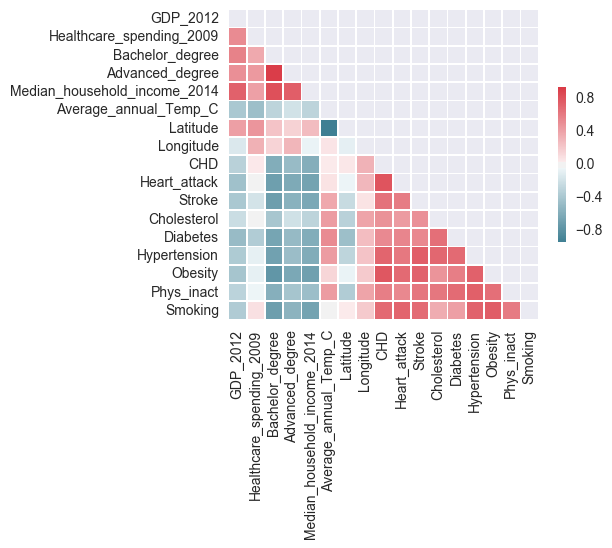

In [15]:
# Computing the correlation matrix
corr = df_sns.corr()

# Generating a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Setting up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 4))

# Generating a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Drawing the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,#xticklabels=0, yticklabels=0,#
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Plotting a diagonal correlation matrix using Seaborn heatmap is a very efficient way of visualizing of multiple correlations. Analysis of the heatmap shows that there is a positive correlation between RF and CVD as well as between many RF. Among various RF, obesity, smoking and hypertension show highest correlation with all three CVD. Geographical factors contribute less to the prevalence of both RF and CVD, though the prevalence of stroke and all RF excluding physical inactivity and obesity is higher in southern states.

Surprisingly, there is not much correlation between healthcare spending and the prevalence of both RF and CVD except diabetes. At the same time, states with higher GDP per capita do have a lower prevalence of both RF and CVD. However, most important socioeconomic factors are education and median household income. The states that have higher education rate (both Bachelor and advanced degrees) and median household income show significantly lower prevalence of both RF and CVD. These socioeconomic factors are positively related between each other.

**Visualizing distribution of prevalence of RF and CVD among U.S. states**

In [16]:
# Creating dataframes for each RF
diabetes = df_merged[['LocationDesc', 'Diabetes']].groupby('LocationDesc').mean().sort_values(by='Diabetes')
hypertension = df_merged[['LocationDesc', 'Hypertension']].groupby('LocationDesc').mean().sort_values(by='Hypertension')
phys_inact = df_merged[['LocationDesc', 'Phys_inact']].groupby('LocationDesc').mean().sort_values(by='Phys_inact')
smoking = df_merged[['LocationDesc', 'Smoking']].groupby('LocationDesc').mean().sort_values(by='Smoking')
obesity = df_merged[['LocationDesc', 'Obesity']].groupby('LocationDesc').mean().sort_values(by='Obesity')
cholesterol = df_merged[['LocationDesc', 'Cholesterol']].groupby('LocationDesc').mean().sort_values(by='Cholesterol')


In [17]:
# Creating a function to get name of a variable / list
def retrieve_name(var):
    """
    Gets the name of variable - does it from the out most frame inner-wards
    :param var: variable to get name from
    :return: string
    """
    for fi in reversed(inspect.stack()):
        names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
        if len(names) > 0:
            return names[0]

In [18]:
def plot_topic(*args):
    """
    Plots a line graph
    :param args: one (or more) pandas series, list, or numpy array
    :return: plot
    """
    colors = ['black', 'red', 'green', 'blue', 'yellow', 'grey', 'pink', 'magenta', 'brown']
    ncolor = 0
    for topic in args:
        name = retrieve_name(topic)
        a = np.array(topic.unstack())
        i = np.arange(len(a))
        plt.plot(i, a, linewidth=2, label=name, color=colors[ncolor])
        ncolor += 1
    plt.ylabel('Prevalence (%)')
    plt.legend(loc=2)
    plt.xlim([-25,55])
    plt.ylim([5,45])
    plt.xlabel('State Rank')

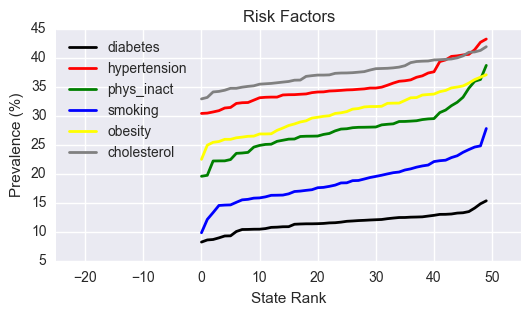

In [19]:
# Plotting state-ranked prevalence of RF
plot_topic(diabetes, hypertension, phys_inact, smoking, obesity, cholesterol)
plt.title('Risk Factors')

In [20]:
# Creating dataframes for each CVD
heart_attack = df_merged[['LocationDesc', 'Heart_attack']].groupby('LocationDesc').mean().sort_values(by='Heart_attack')
CHD = df_merged[['LocationDesc', 'CHD']].groupby('LocationDesc').mean().sort_values(by='CHD')
stroke = df_merged[['LocationDesc', 'Stroke']].groupby('LocationDesc').mean().sort_values(by='Stroke')

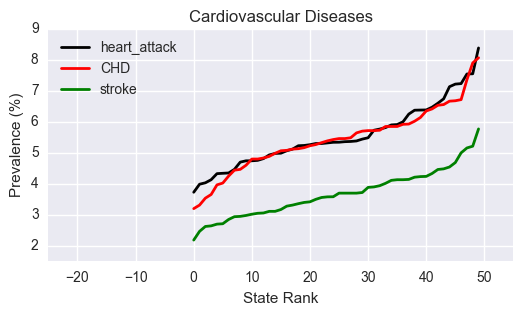

In [21]:
# Plotting state-ranked prevalence of CVD
plot_topic(heart_attack, CHD, stroke)
plt.ylim([1.5,9])
plt.title('Cardiovascular Diseases')

Distribution of the prevalence of most RF and all three CVD is well described by a logistic function.

**Statistical description of the prevalence of RF and CVD among U.S. population**

In [22]:
# Creating a function to get statistics on topics (CVD and RF)
def statdesc_topic (*args):
    """
    Gets statistics
    :param args: one (or more) strings
    :return: print the object name and statistics
    """
    for i in args:
        a = df3[(df3.Topic == i)].sort_values(by='Data_Value')['Data_Value']
        n = len(a)
        mean = np.mean(a)
        std = np.std(a)
        sem = stats.sem(a)
        skewness = stats.skew(a)
        print('Group name: ', i)
        print('n: ', n)
        print('mean: ', mean)
        print('std: ', std)
        print('skewness: ', skewness)
        print('----------------------------------')

In [23]:
# Getting statistics on RF
statdesc_topic('Hypertension', 'Obesity', 'Smoking', 'Phys_inact', 'Diabetes', 'Cholesterol')

Group name:  Hypertension
n:  448
mean:  35.206250000000004
std:  12.648074961163626
skewness:  0.8291973551909884
----------------------------------
Group name:  Obesity
n:  413
mean:  30.33317191283292
std:  6.639914441380095
skewness:  -0.33270837479028714
----------------------------------
Group name:  Smoking
n:  403
mean:  18.670223325062025
std:  6.084357905019971
skewness:  -0.07549730728899454
----------------------------------
Group name:  Phys_inact
n:  438
mean:  27.699999999999985
std:  5.954657438130208
skewness:  0.41782667909584753
----------------------------------
Group name:  Diabetes
n:  416
mean:  11.720913461538462
std:  5.407239638830689
skewness:  0.6073174944331317
----------------------------------
Group name:  Cholesterol
n:  436
mean:  37.436697247706405
std:  9.488637923447497
skewness:  0.393228292911245
----------------------------------


In [24]:
# Getting statistics on CVD
statdesc_topic('Heart_attack', 'CHD', 'Stroke')

Group name:  Heart_attack
n:  337
mean:  5.499999999999999
std:  3.531502987838992
skewness:  1.321397929366628
----------------------------------
Group name:  CHD
n:  319
mean:  5.38025078369906
std:  3.4234419516097687
skewness:  1.438244720501297
----------------------------------
Group name:  Stroke
n:  323
mean:  3.6730650154798763
std:  2.139887779264906
skewness:  1.2254180820175533
----------------------------------


In [25]:
# Creating a function to plot probability density for topics
def plot_pdf_topic(*args):
    """
    Plots a line graph
    :param args: one (or more) strings
    :return: plot
    """
    colors = ['black', 'red', 'green', 'blue', 'yellow', 'grey', 'pink', 'magenta', 'brown']
    ncolor = 0
    
    for i in args:
        a = df3[(df3.Topic == i)].sort_values(by='Data_Value')['Data_Value']
        pdf = stats.norm.pdf(a, np.mean(a), np.std(a))
        plt_fit = plt.plot(a, pdf, linewidth=2, label=i, color=colors[ncolor])
        ncolor += 1
    plt.xlabel('Prevalence {%}')
    plt.ylabel('Probability Density')
    plt.legend(loc=2)

(-23, 80)

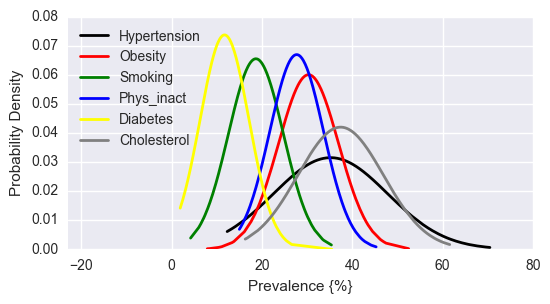

In [26]:
# Plotting probability density for RF
plot_pdf_topic('Hypertension', 'Obesity', 'Smoking', 'Phys_inact', 'Diabetes', 'Cholesterol')
plt.xlim([-23,80])

(-5, 20)

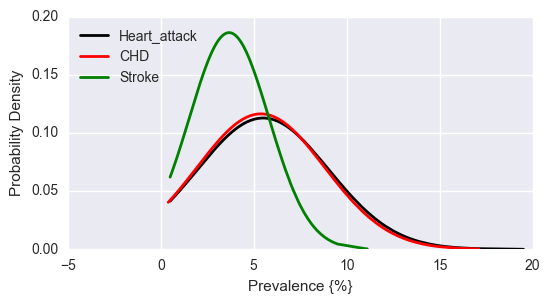

In [27]:
# Plotting probability density for CVD
plot_pdf_topic('Heart_attack', 'CHD', 'Stroke')
plt.xlim([-5,20])

Skewness and probability density results indicate that distribution of prevalence of all RF and CVD among U.S. population is normal. Sample size is high and similar for all RF and CVD. Therefore, combined prevalence of RF and CVD will be used in further analysis to simplify data analysis and visualization. There is no need to calculate average RF and CVD values, since there are already two categories: risk factors and cardiovascular diseases that include all RF and CVD, respectively, in the original data file.

**Ranking U.S. states by the prevalence of RF and CVD**

In [28]:
# Creating dataframes containing combined prevalence of RF and CVD
cvd = df3[df3.Category == 'Cardiovascular Diseases']
rf = df3[df3.Category == 'Risk Factors']

In [29]:
# Preparing lists of states and series with prevalence of CVD and RF 
graph = cvd[['LocationDesc', 'Data_Value']].groupby('LocationDesc').mean().sort_values(by='Data_Value')
graph1 = graph.unstack().reset_index()
graph1 = graph1.drop('level_0', 1)
graph1 = graph1.rename(columns={0: 'CVD'})
name_list = graph1.LocationDesc.tolist()
fimp = graph1.CVD

graph2 = rf[['LocationDesc', 'Data_Value']].groupby('LocationDesc').mean().sort_values(by='Data_Value')
graph3 = graph2.unstack().reset_index()
graph3 = graph3.drop('level_0', 1)
graph3 = graph3.rename(columns={0: 'RF'})
name_list1 = graph3.LocationDesc.tolist()
fimp1 = graph3.RF

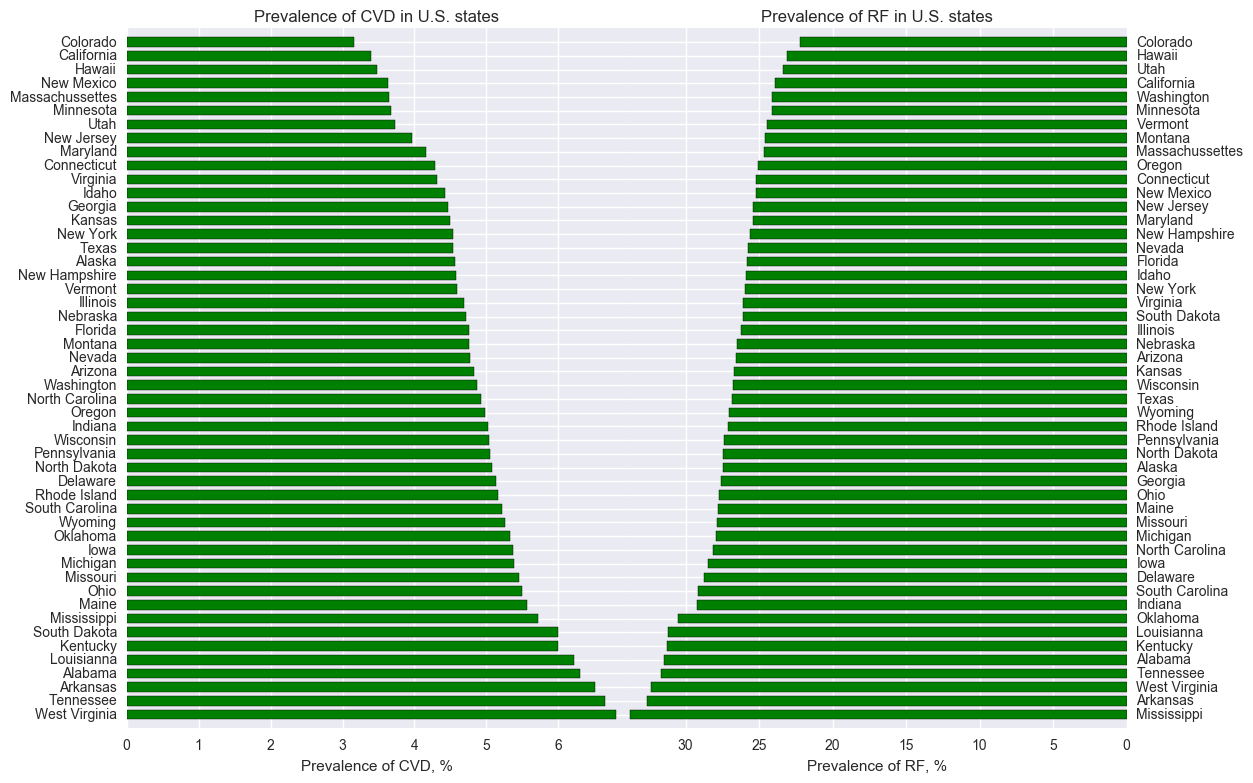

In [30]:
# Plotting sorted combined prevalence of CVD and RF for U.S. states  
fimp, name_list = zip(*sorted(zip(fimp, name_list), reverse=True))
fimp1, name_list1 = zip(*sorted(zip(fimp1, name_list1), reverse=True))

from pylab import rcParams
#rcParams['figure.figsize'] = 5, 9
plt.figure(figsize = (5,7))
plt.subplot(221)
plt.barh(range(len(name_list)), fimp, align='center', height=0.7, color='green')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Prevalence of CVD, %')
plt.ylim((-1, len(name_list)))
plt.xlim((0, (int(max(fimp))+0.95)))
plt.tick_params(
    axis='y',
    which='both',     
    left='on',  
    right='off',   
    labelright='off')
#plt.ylabel('States')
plt.title('Prevalence of CVD in U.S. states')

plt.subplot(222)
plt.barh(range(len(name_list1)), fimp1, align='center', height=0.7, color='green')
plt.yticks(range(len(name_list1)),name_list1)
plt.xlabel('Prevalence of RF, %')
plt.ylim((-1, len(name_list1)))
plt.xlim(((int(max(fimp1))+1), 0))
plt.tick_params(axis='y', labelleft='off', labelright='on')
plt.tick_params(
    axis='y',
    which='both',     
    left='off',  
    right='on',   
    labelleft='off')
#plt.ylabel('States')
plt.title('Prevalence of RF in U.S. states')

plt.subplots_adjust(top=2, bottom=0, left=0, right=2, hspace=0, wspace=0.0)

plt.show()

The analysis shows that Colorado, Hawaii, and California are among the four states with lowest prevalence rate of RF and CVD. Arkansas, Tennessee, and West Virginia are among the four states with highest prevalence of RF and CVD.

**Visualizating correlation between the prevalence of RF and CVD for U.S. states using Seaborn Jointplot**

In [31]:
# Creating new dataframes for RF and CVD including location ID which is to be used a key for merging
# Grouping by state and calculating mean combined prevalence values for each state
rf1 = df3[(df3.Category == 'Risk Factors')][['LocationID', 'LocationDesc', 'Data_Value']].groupby(['LocationID', 'LocationDesc']).mean().reset_index()
cvd1 = df3[df3.Category == 'Cardiovascular Diseases'][['LocationID', 'Data_Value']].groupby('LocationID').mean().reset_index()

# Merging dataframes
df_cvd_rf = pd.merge(rf1, cvd1, on='LocationID', how='inner')
df_cvd_rf = df_cvd_rf.rename(columns={'Data_Value_x': 'RF', 'Data_Value_y': 'CVD'})
df_cvd_rf.head()

,LocationID,LocationDesc,RF,CVD
0,1.0,Alabama,31.460417,6.305263
1,2.0,Alaska,27.472549,4.566667
2,4.0,Arizona,26.554000,4.826667
3,5.0,Arkansas,32.610000,6.510000
4,6.0,California,23.946296,3.400000


C:\Users\Igor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


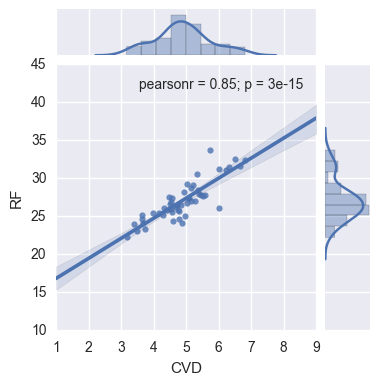

In [32]:
# Correlation between prevalence of RF and CVD
sns.jointplot(df_cvd_rf.CVD, df_cvd_rf.RF, kind='reg', size=4)

Correlation between the prevalence of RF and CVD is statistically significant at the 0.1% level.

**Visualizing correlations between CVD and socioeconomic factors**

In [33]:
# Creating a dataframe merging CVD and RF with US states socioeconomic data
df_us_del = df_us.drop('LocationDesc', axis=1)
df4 = pd.merge(df_cvd_rf, df_us_del, on='LocationID', how='inner')
# Changing $US values in columns to thousands
df4[['GDP_2012']] = df4.GDP_2012/1000
df4[['Healthcare_spending_2009']] = df4.Healthcare_spending_2009/1000
df4[['Median_household_income_2014']] = df4.Median_household_income_2014/1000
df4.head()

,LocationID,LocationDesc,RF,CVD,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C
0,1.0,Alabama,31.460417,6.305263,32.615,6.27167,0.235,0.087,41.415,17.1
1,2.0,Alaska,27.472549,4.566667,61.156,9.12765,0.280,0.110,60.287,-3.0
2,4.0,Arizona,26.554000,4.826667,35.195,5.43389,0.275,0.102,46.709,15.7
3,5.0,Arkansas,32.610000,6.510000,31.837,6.16694,0.211,0.075,38.758,15.8
4,6.0,California,23.946296,3.400000,46.029,6.23761,0.314,0.116,67.458,15.2


C:\Users\Igor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


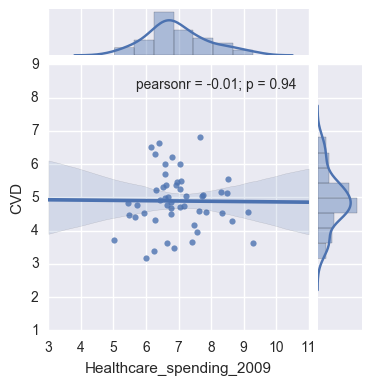

In [34]:
# Correlation between prevalence of CVD and healthcare spending 
sns.jointplot(df4.Healthcare_spending_2009, df4.CVD, kind='reg', size=4)

C:\Users\Igor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


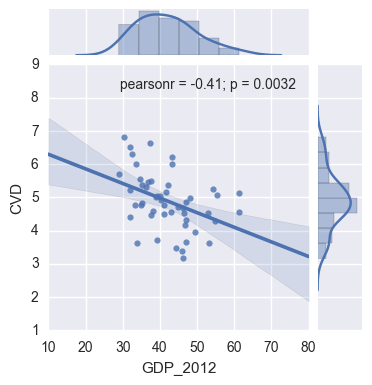

In [35]:
# Correlation between prevalence of CVD and GDP
sns.jointplot(df4.GDP_2012, df4.CVD, kind='reg', size=4)

C:\Users\Igor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


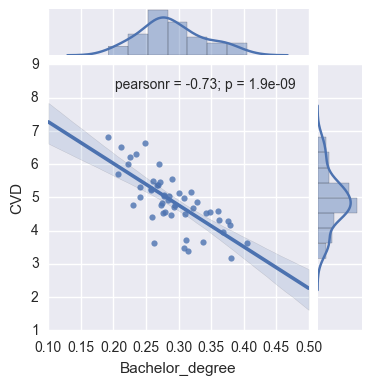

In [36]:
# Correlation between prevalence of CVD and the level of education 
sns.jointplot(df4.Bachelor_degree, df4.CVD, kind='reg', size=4)

C:\Users\Igor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


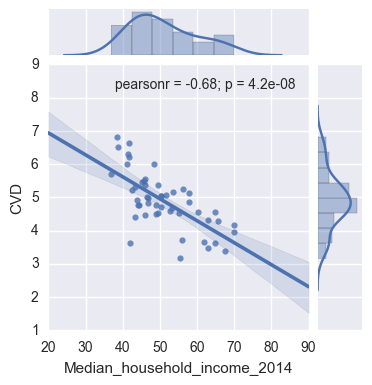

In [37]:
# Correlation between prevalence of CVD and median household income 
sns.jointplot(df4.Median_household_income_2014, df4.CVD, kind='reg', size=4)

C:\Users\Igor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


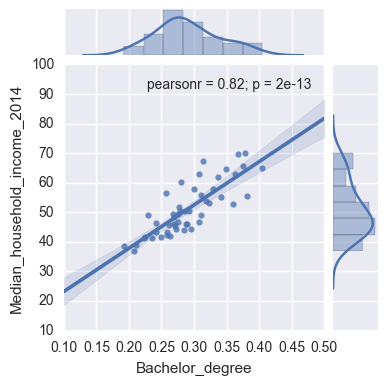

In [38]:
# Correlation between the level of education and median household income
sns.jointplot(df4.Bachelor_degree, df4.Median_household_income_2014, kind='reg', size=4)

C:\Users\Igor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


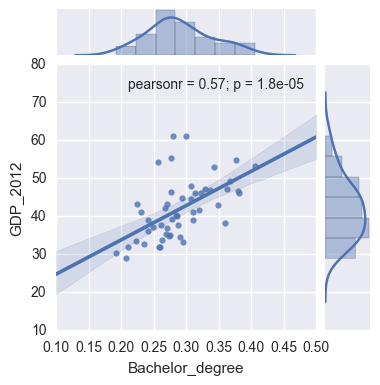

In [39]:
# Correlation between the level of education and GDP
sns.jointplot(df4.Bachelor_degree, df4.GDP_2012, kind='reg', size=4)

C:\Users\Igor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


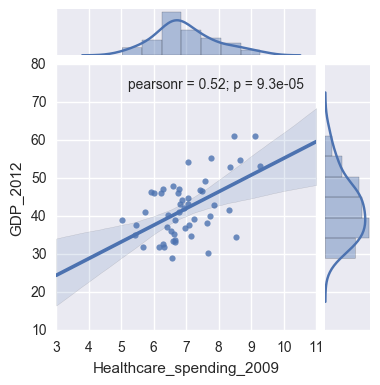

In [40]:
# Correlation between GDP and healthcare spending
sns.jointplot(df4.Healthcare_spending_2009, df4.GDP_2012, kind='reg', size=4)

The analysis confirms the previously drawn conclusion that an increase in healthcare spending does not reduce the prevalence of both RF and CVD, and, with the 0.1% significance level, higher education level and household income are crucial factors in decreasing the prevalence of RF and CVD. There is also statistically significant positive relationship at the 1% level between GDP and both RF and CVD, though the correlation coefficient is lower.

**Determining the difference in the prevalence of RF and CVD between various demographic groups**

##### 1) Gender

In [41]:
# Creating a function to get total statistics for RF and CVD on break out groups
def statdesc_group (*args, category):
    """
    Gets statistics
    :param args: one (or more) strings
    :param category: string
    :return: print the object name and statistic
    """
    print('Category: ', category)
    print('**********************************')
    
    for i in args:
        a = df3[(df3.Category == category) & (df3.Break_out == i)].sort_values(by='Data_Value')['Data_Value']
        n = len(a)
        mean = np.mean(a)
        std = np.std(a)
        sem = stats.sem(a)
        skewness = stats.skew(a)
        print('Group name: ', i)
        print('n: ', n)
        print('mean: ', mean)
        print('std: ', std)
        print('skewness: ', skewness)
        print('----------------------------------')

In [42]:
# Getting statistics on combined RF in the gender groups
statdesc_group('Male', 'Female', category='Risk Factors')

Category:  Risk Factors
**********************************
Group name:  Male
n:  300
mean:  26.253333333333323
std:  9.502050071198084
skewness:  -0.44139306624627067
----------------------------------
Group name:  Female
n:  300
mean:  24.124000000000002
std:  9.091205860610568
skewness:  -0.46424999859542526
----------------------------------


In [43]:
# Creating a function to plot probability density of combined RF or CVD in groups
def plot_pdf_group(*args, category):
    """
    Plots a line graph
    :param args: one (or more) strings
    :param category: string
    :return: plot
    """
    colors = ['black', 'red', 'green', 'blue', 'yellow', 'grey', 'pink', 'magenta', 'brown']
    ncolor = 0
    
    for i in args:
        a = df3[(df3.Category == category) & (df3.Break_out == i)].sort_values(by='Data_Value')['Data_Value']
        pdf = stats.norm.pdf(a, np.mean(a), np.std(a))
        plt_fit = plt.plot(a, pdf, linewidth=2, label=i, color=colors[ncolor])
        ncolor += 1
    plt.xlabel('Prevalence, %')
    plt.legend(loc=2)
    plt.ylabel('Probability Density')

(0, 50)

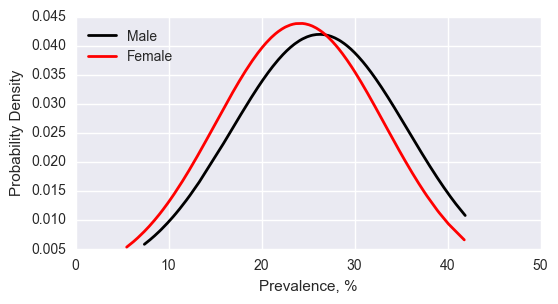

In [44]:
# Plotting probability density for combined RF in gender groups
plot_pdf_group('Male', 'Female', category='Risk Factors')
plt.xlim([0,50])

In [45]:
# Creating a function to calculate confidence intervals
def ConfInt_group(*args, category, level):
    """
    Determines confidence intervals at confidence level
    :param args: one (or more) strings
    :param level: float 
    :param category: string
    :return: confidence intervals
    """
    print('Category: ', category)
    print('**********************************')
    
    for i in args:
        a = df3[(df3.Category == category) & (df3.Break_out == i)].sort_values(by='Data_Value')['Data_Value']
        int1, int2 = stats.norm.interval(level, loc=np.mean(a), scale=stats.sem(a))
        print('Group name: ', i)
        print(int1, '-', int2)
        print('---------------------------------')

In [46]:
# Calculating confidence intervals for combined RF in the gender groups
ConfInt_group('Male', 'Female', category='Risk Factors', level=0.95)

Category:  Risk Factors
**********************************
Group name:  Male
25.1762983461 - 27.3303683205
---------------------------------
Group name:  Female
23.0935332361 - 25.1544667639
---------------------------------


In [47]:
# Creating RF series for all break out groups for Anova test
rf_male = df3[(df3.Category == 'Risk Factors') & (df3.Break_out == 'Male')]['Data_Value']
rf_female = df3[(df3.Category == 'Risk Factors') & (df3.Break_out == 'Female')]['Data_Value']
rf_race_b = df3[(df3.Category == 'Risk Factors') & (df3.Break_out == 'Non-Hispanic Black')]['Data_Value']
rf_race_w = df3[(df3.Category == 'Risk Factors') & (df3.Break_out == 'Non-Hispanic White')]['Data_Value']
rf_race_h = df3[(df3.Category == 'Risk Factors') & (df3.Break_out == 'Hispanic')]['Data_Value']
rf_race_o = df3[(df3.Category == 'Risk Factors') & (df3.Break_out == 'Other')]['Data_Value']
rf_25_44 = df3[(df3.Category == 'Risk Factors') & (df3.Break_out == '25-44')]['Data_Value']
rf_45_64 = df3[(df3.Category == 'Risk Factors') & (df3.Break_out == '45-64')]['Data_Value']
rf_65 = df3[(df3.Category == 'Risk Factors') & (df3.Break_out == '65+')]['Data_Value']

In [48]:
# One-way Anova test
# computing the f test statistic and p value for RF in the gender groups
f_val, p_val = stats.f_oneway(rf_male, rf_female)
print('Category: ', 'Risk Factors')
print('****************************')
print('f value: ', f_val)
print('p value: ', p_val)

Category:  Risk Factors
****************************
f value:  7.83908911902
p value:  0.00527795393521


In [49]:
# Getting statistics on combined CVD in the gender groups
statdesc_group('Male', 'Female', category='Cardiovascular Diseases')

Category:  Cardiovascular Diseases
**********************************
Group name:  Male
n:  150
mean:  4.552666666666668
std:  1.5495245148826213
skewness:  0.2312243602122519
----------------------------------
Group name:  Female
n:  150
mean:  2.930666666666666
std:  0.7231363787158146
skewness:  0.664103194645088
----------------------------------


(0, 10)

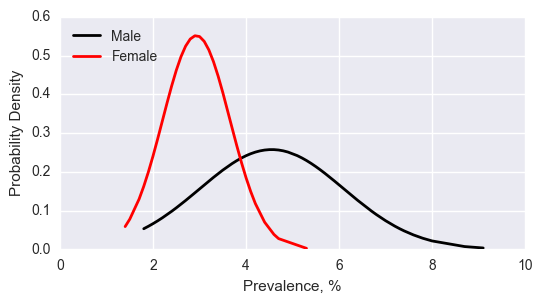

In [50]:
# Plotting probability density for combined CVD in the gender groups
plot_pdf_group('Male', 'Female', category='Cardiovascular Diseases')
plt.xlim([0,10])

In [51]:
# Calculating confidence intervals for combined CVD in the gender groups
ConfInt_group('Male', 'Female', category='Cardiovascular Diseases', level=0.95)

Category:  Cardiovascular Diseases
**********************************
Group name:  Male
4.30386492947 - 4.80146840386
---------------------------------
Group name:  Female
2.81455518503 - 3.0467781483
---------------------------------


In [52]:
# Creating CVD series for all break out groups for Anova test
cvd_male = df3[(df3.Category == 'Cardiovascular Diseases') & (df3.Break_out == 'Male')]['Data_Value']
cvd_female = df3[(df3.Category == 'Cardiovascular Diseases') & (df3.Break_out == 'Female')]['Data_Value']
cvd_race_b = df3[(df3.Category == 'Cardiovascular Diseases') & (df3.Break_out == 'Non-Hispanic Black')]['Data_Value']
cvd_race_w = df3[(df3.Category == 'Cardiovascular Diseases') & (df3.Break_out == 'Non-Hispanic White')]['Data_Value']
cvd_race_h = df3[(df3.Category == 'Cardiovascular Diseases') & (df3.Break_out == 'Hispanic')]['Data_Value']
cvd_race_o = df3[(df3.Category == 'Cardiovascular Diseases') & (df3.Break_out == 'Other')]['Data_Value']
cvd_25_44 = df3[(df3.Category == 'Cardiovascular Diseases') & (df3.Break_out == '25-44')]['Data_Value']
cvd_45_64 = df3[(df3.Category == 'Cardiovascular Diseases') & (df3.Break_out == '45-64')]['Data_Value']
cvd_65 = df3[(df3.Category == 'Cardiovascular Diseases') & (df3.Break_out == '65+')]['Data_Value']

In [53]:
# One-way Anova
# computing the f test statistic and p value for CVD in the gender groups
f_val, p_val = stats.f_oneway(cvd_male, cvd_female)
print('Category: ', 'Cardiovascular Diseases')
print('***********************************')
print('f value: ', f_val)
print('p value: ', p_val)

Category:  Cardiovascular Diseases
***********************************
f value:  134.065694791
p value:  7.52884301904e-26


The analysis shows that there is a statically significant difference in the prevalence of both RF and CVD at the 1% and 0.1% level, respectively, between males and females. However, the difference in the prevalence of CVD is much bigger, which implies that other, non-traditional risk factors including gender differences contribute to the pathophysiological mechanisms of CVD.

##### 2) Race / ethnicity

In [54]:
# Getting statistics on combined RF in the race groups
statdesc_group('Non-Hispanic Black', 'Non-Hispanic White', 'Hispanic', 'Other', category='Risk Factors')

Category:  Risk Factors
**********************************
Group name:  Non-Hispanic Black
n:  261
mean:  31.92835249042146
std:  10.324213660476428
skewness:  -0.37201962406579764
----------------------------------
Group name:  Non-Hispanic White
n:  300
mean:  24.25300000000001
std:  9.226315136607896
skewness:  -0.4815708682888628
----------------------------------
Group name:  Hispanic
n:  274
mean:  28.302919708029187
std:  9.775691896702076
skewness:  -0.34802705529323064
----------------------------------
Group name:  Other
n:  219
mean:  24.049771689497724
std:  10.05743494459543
skewness:  0.08265286898989616
----------------------------------


(-10, 60)

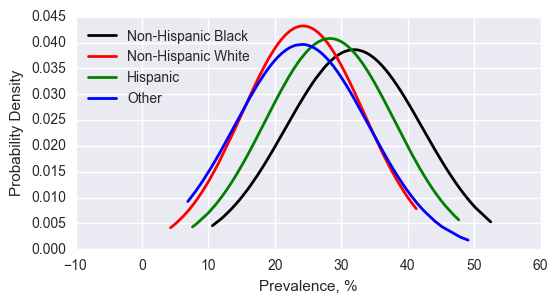

In [55]:
# Plotting probability density for combined RF in the race groups
plot_pdf_group('Non-Hispanic Black', 'Non-Hispanic White', 'Hispanic', 'Other', category='Risk Factors')
plt.xlim([-10,60])

In [56]:
# Calculating confidence intervals for combined RF in the race groups
ConfInt_group('Non-Hispanic Black', 'Non-Hispanic White', 'Hispanic', 'Other', category='Risk Factors', level=0.95)

Category:  Risk Factors
**********************************
Group name:  Non-Hispanic Black
30.6734256712 - 33.1832793096
---------------------------------
Group name:  Non-Hispanic White
23.207218918 - 25.298781082
---------------------------------
Group name:  Hispanic
27.1433035108 - 29.4625359052
---------------------------------
Group name:  Other
22.7146923467 - 25.3848510323
---------------------------------


In [57]:
# One-way Anova
# computing the f test statistic and p value for RF in the race groups
f_val, p_val = stats.f_oneway(rf_race_b, rf_race_w, rf_race_h, rf_race_o)
print('Category: ', 'Risk Factors')
print('****************************')
print('f value: ', f_val)
print('p value: ', p_val)

Category:  Risk Factors
****************************
f value:  37.6727582928
p value:  3.9981650601e-23


In [58]:
# Getting statistics on combined CVD in the race groups
statdesc_group('Non-Hispanic Black', 'Non-Hispanic White', 'Hispanic', 'Other', category='Cardiovascular Diseases')

Category:  Cardiovascular Diseases
**********************************
Group name:  Non-Hispanic Black
n:  84
mean:  4.3202380952380945
std:  1.1837973364503098
skewness:  1.1638438939395974
----------------------------------
Group name:  Non-Hispanic White
n:  150
mean:  3.588666666666665
std:  1.0285612389266001
skewness:  0.4955345463578675
----------------------------------
Group name:  Hispanic
n:  34
mean:  3.705882352941177
std:  1.3525446989396535
skewness:  0.5623229360269799
----------------------------------
Group name:  Other
n:  45
mean:  5.846666666666666
std:  3.0164438223400305
skewness:  0.6656987277792743
----------------------------------


(-5, 15)

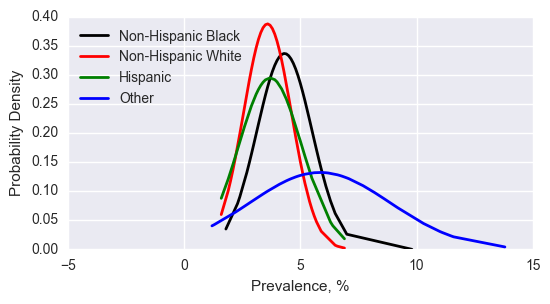

In [59]:
# Plotting probability density for combined CVD in the race groups
plot_pdf_group('Non-Hispanic Black', 'Non-Hispanic White', 'Hispanic', 'Other', category='Cardiovascular Diseases')
plt.xlim([-5,15])

In [60]:
# Calculating confidence intervals for combined CVD in the race groups
ConfInt_group('Non-Hispanic Black', 'Non-Hispanic White', 'Hispanic', 'Other', category='Cardiovascular Diseases', level=0.95)

Category:  Cardiovascular Diseases
**********************************
Group name:  Non-Hispanic Black
4.06556304336 - 4.57491314712
---------------------------------
Group name:  Non-Hispanic White
3.42351418241 - 3.75381915093
---------------------------------
Group name:  Hispanic
3.2444131236 - 4.16735158228
---------------------------------
Group name:  Other
4.95538085249 - 6.73795248084
---------------------------------


In [61]:
# One-way Anova
# computing the f test statistic and p value for CVD in the race groups
f_val, p_val = stats.f_oneway(cvd_race_b, cvd_race_w, cvd_race_h, cvd_race_o)
print('Category: ', 'Cardiovascular Diseases')
print('****************************')
print('f value: ', f_val)
print('p value: ', p_val)

Category:  Cardiovascular Diseases
****************************
f value:  25.5699028868
p value:  8.39678545655e-15


The analysis shows that there is a statically significant difference in the prevalence of both RF and CVD at the 0.1% level between different races / ethnic groups. Hispanic is rather an ethnic group then a race. It is not clear from metadata who represents the Other race / ethnic group. Asians are not included in this group. Based on 2010 U.S. the other group seems to include Hispanic Mestizos (contributing most), Native American or Alaska Native, Native Hawaiians or Other Pacific Islander, Middle Eastern ethnic group, and multiracial group. White race and Hispanic ethnic group have the lowest prevalence of CVD, and are followed by Black race. The prevalence of CVD is much higher in the Other group in comparison to the others. Surprisingly, the Other group along with the White race have lowest prevalence of RF, while Hispanic group has high prevalence following the Black race.

These findings are in agreement with previously observed phenomenon known as Hispanic Paradox and imply that other, non-traditional risk factors contribute to the pathophysiological mechanisms of CVD. Our results are in agreement with the hypothesis that decisive factor contributing to the Hispanic paradox appears to be place of birth, raising the possibility that differing birthing or neonatal practices might be involved via a lack of breastfeeding combined with birth trauma imprinting (both common in American obstetrics) and consequent mental and physical illness, the latter compounded by the impact of psychological problems on the capacity for social networking.

##### 3) Age

In [62]:
# Getting statistics on combined RF in the age groups
statdesc_group('25-44', '45-64', '65+', category='Risk Factors')

Category:  Risk Factors
**********************************
Group name:  25-44
n:  300
mean:  19.868999999999993
std:  8.847542351787116
skewness:  -0.6012123737401234
----------------------------------
Group name:  45-64
n:  300
mean:  30.167666666666683
std:  11.962256805840981
skewness:  -0.04875479727234307
----------------------------------
Group name:  65+
n:  300
mean:  34.66566666666667
std:  19.129374999954624
skewness:  0.2843746190656368
----------------------------------


(-10, 80)

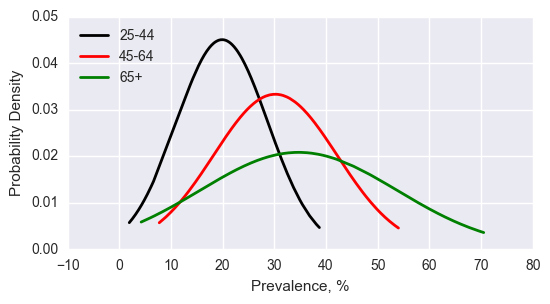

In [63]:
# Plotting probability density for combined RF in the age groups
plot_pdf_group('25-44', '45-64', '65+', category='Risk Factors')
plt.xlim([-10,80])

In [64]:
# Calculating confidence intervals for combined RF in the age groups
ConfInt_group('25-44', '45-64', '65+', category='Risk Factors', level=0.95)

Category:  Risk Factors
**********************************
Group name:  25-44
18.8661519207 - 20.8718480793
---------------------------------
Group name:  45-64
28.8117730427 - 31.5235602906
---------------------------------
Group name:  65+
32.4973970823 - 36.833936251
---------------------------------


In [65]:
# One-way Anova
# computing the f test statistic and p value for RF in the age groups
f_val, p_val = stats.f_oneway(rf_25_44, rf_45_64, rf_65)
print('Category: ', 'Risk Factors')
print('****************************')
print('f value: ', f_val)
print('p value: ', p_val)

Category:  Risk Factors
****************************
f value:  87.8802968363
p value:  1.40248926575e-35


In [66]:
# Getting statistics on combined CVD in the age groups
statdesc_group('25-44', '45-64', '65+', category='Cardiovascular Diseases')

Category:  Cardiovascular Diseases
**********************************
Group name:  25-44
n:  66
mean:  1.0772727272727274
std:  0.41879895174590764
skewness:  0.8059114221613563
----------------------------------
Group name:  45-64
n:  150
mean:  4.228666666666666
std:  1.4043901009176745
skewness:  0.6884320293896322
----------------------------------
Group name:  65+
n:  150
mean:  10.920000000000003
std:  2.7865390720390053
skewness:  0.09381668613663416
----------------------------------


(-5, 20)

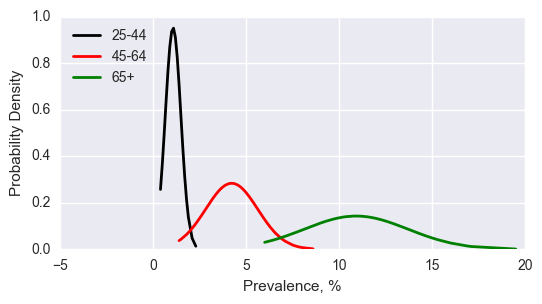

In [67]:
# Plotting probability density for combined CVD in the age groups
plot_pdf_group('25-44', '45-64', '65+', category='Cardiovascular Diseases')
plt.xlim([-5,20])

In [68]:
# One-way Anova test
# computing the f test statistic and p value for the age groups
f_val, p_val = stats.f_oneway(cvd_25_44, cvd_45_64, cvd_65)
print('Category: ', 'Cardiovascular Diseases')
print('****************************')
print('f value: ', f_val)
print('p value: ', p_val)

Category:  Cardiovascular Diseases
****************************
f value:  695.555345651
p value:  6.70977171697e-125


As expected, aging is significant factor leading to CVD, though the difference in the prevalence of RF among the age groups is smaller than that of CVD.

**Plotting the prevalence of CVD and RF in various demographic groups**

In [69]:
def statdesc_group1 (group, category):
    """
    Gets statistics
    :param args: one (or more) strings
    :param category: string
    :return: mean and sem
    """
    a = df3[(df3.Category == category) & (df3.Break_out == group)].sort_values(by='Data_Value')['Data_Value']
    mean = np.mean(a)
    std = np.std(a)
    #sem = stats.sem(a)
    return mean, std

In [70]:
def prevalence_plot (*args, category):
    """
    Gets statistics
    :param args: one (or more) strings
    :param category: string
    :return: bar chart
    """
    objects = []
    prevalence = []
    yerr = []
    
    for group in args:
        mean, std = statdesc_group1(group, category)
        prevalence.append(mean)
        yerr.append(std)
        if group == 'Non-Hispanic Black':
            group = 'Black'
        elif group == 'Non-Hispanic White':
            group = 'White'
        objects.append(group)

    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, prevalence, align='center', alpha=0.5, color='green', yerr = yerr)
    plt.xticks(y_pos, objects)
    plt.ylabel('Prevalence, %')
    if category == 'Cardiovascular Diseases':
        plt.title('Prevalence of CVD by group')
    elif category == 'Risk Factors':
        plt.title('Prevalence of RF by group')
 
    plt.show()

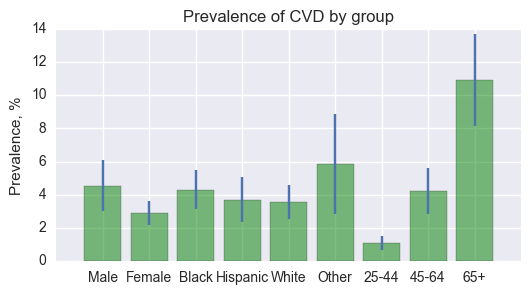

In [71]:
prevalence_plot('Male', 'Female', 'Non-Hispanic Black', 'Hispanic', 'Non-Hispanic White', 'Other', '25-44', '45-64', '65+', category='Cardiovascular Diseases')

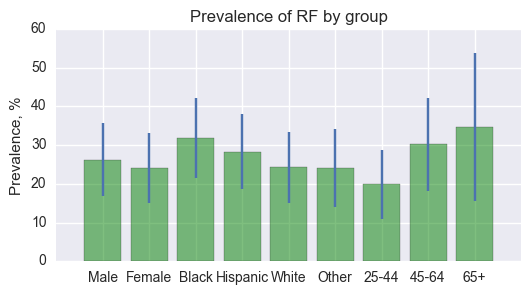

In [72]:
prevalence_plot('Male', 'Female', 'Non-Hispanic Black', 'Hispanic', 'Non-Hispanic White', 'Other', '25-44', '45-64', '65+', category='Risk Factors')

All demographic groups are depicted in the same bar plot for the purpose of more effective visualization. However, it has to be noted that comparison between gender, age, race / ethnic categories is not correct, since they are interconnected and include the same data points. Only internal category comparison (e.g. between gender groups - males and females) is correct.

## Machine Learning Modelling

The data analysis shows that there is a strong correlation between the prevalence of traditional risk factors among U.S. population, some of socioeconomic characteristics of U.S. states and the prevalence of CVD. They are interrelated, though is not known what factors contribute most to the prevalence of CVD. However, efforts aimed at reducing the prevalence of CVD need to target specific factors. This approach would allow one to optimize healthcare spending and to estimate future risks of CVD more accurate. Prediction of the prevalence of CVD based on risk and socioeconomic factors is possible if potential predictive influence of each factor is determined. This is achieved by building a predictive model.

In this study, supervised machine learning will be used for predictive modelling of the prevalence of three CVD – CHD, heart attack, and stroke in U.S. states. Unsupervised learning will be used for identifying clusters of U.S. states that have similar prevalence of risk factors and socioeconomic characteristics. The states in the same clusters can be treated / assessed similarly. Analysis of the characteristics of successful states with low prevalence of CVD and risk factors would allow one to develop effective strategies for reducing the occurrence of the diseases.

## Supervised Learning

Supervised machine learning algorithms use labeled training data to build a model. Therefore, training and test data sets will be created from the primary dataset, a predictive model will be trained using the training data, and then the model’s predictive accuracy will be determined using the test data.

**Linear Regression Model**

Linear regression model will be used first to resolve the regression problem. Though most of the time relationships are never truly linear, linear regression model is a good approach to start with considering simplicity is an important factor in the model selection process. The prevalence of CHD in U.S. states as a target (dependent variable) will be tested first.

In [73]:
# Creating a dataframe with features (predictors) to be analyzed
df_X = df_merged.drop(df_merged.ix[:,'CHD':'Stroke'].head(0).columns, 1)
df_X = df_X.drop(df_X.ix[:,'LocationID':'LocationDesc'].head(0).columns, 1)

In [74]:
# Defining independent and dependent variables for regression
X = df_X.values
Y = df_merged['CHD'].values #reshape(-1, 1)

In [75]:
df_X.head(3)

,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude,Cholesterol,Diabetes,Hypertension,Obesity,Phys_inact,Smoking
0,32615,6271.67,0.235,0.087,41415,17.1,32.8405,-86.6318,41.925000,15.414286,40.611111,33.175000,31.777778,21.414286
1,61156,9127.65,0.280,0.110,60287,-3.0,64.8450,-147.7220,37.044444,8.757143,36.666667,31.677778,24.650000,21.566667
2,35195,5433.89,0.275,0.102,46709,15.7,34.8659,-111.7638,39.687500,12.622222,34.522222,28.975000,27.000000,15.871429


In [76]:
# Random 80%/20% split to training and testing data sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(40, 14)
(10, 14)
(40,)
(10,)


In [77]:
from sklearn.linear_model import LinearRegression

# Creating an instance of the linear regression model
lm = LinearRegression(normalize=True)

# Training the model with all the 14 predictors only using the training set
lm.fit(X_train, Y_train)

# Checking how much of the variance in the data sets is explained by the model by determining R-squared
print("R-squared for training data: ")
print(lm.score(X_train, Y_train))

print("R-squared for test data: ")
print(lm.score(X_test, Y_test))
print()

# Predicting the output on the test set for first five values
print("predictions for 5 states in the test set:")
print(lm.predict(X_test)[0:5])
print()

# Determining mean squared error (MSE) on the data sets
from sklearn.metrics import mean_squared_error
print("MSE on the training set: ")
print(mean_squared_error(Y_train, lm.predict(X_train)))
print()
print("MSE on the test set: ")
print(mean_squared_error(Y_test, lm.predict(X_test)))

R-squared for training data: 
0.735583896422
R-squared for test data: 
0.610460606071

predictions for 5 states in the test set:
[ 5.35876534  4.78956993  4.44047257  4.77290766  4.72836337]

MSE on the training set: 
0.286362269312

MSE on the test set: 
0.438345425877


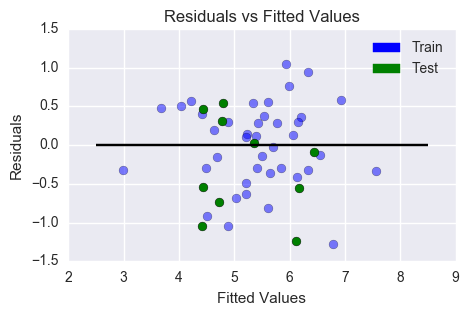

In [78]:
# Visualizing goodness of fit by plotting residuals for both data sets
import matplotlib.patches as mpatches

plt.figure(figsize=(5,3))
plt.scatter(lm.predict(X_train), lm.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(lm.predict(X_test), lm.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y = 0, xmin=2.5, xmax = 8.5)

plt.title('Residuals vs Fitted Values')
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')

blue_patch = mpatches.Patch(color='b', label='Train')
green_patch = mpatches.Patch(color ='g', label='Test')
plt.legend(handles=[blue_patch, green_patch])
plt.show()

The liner regression model explains 74% / 61% of the variance in the training/test data sets, respectively. It is normal that R-squared value for a training data set is higher than that for a test set, which is the case for the proposed model.  However, this model does not generate the values of regression coefficients. Therefore, ordinary least squares (OLS) method will be used to estimate these parameters.

In [79]:
# Using StatsModels module OLS model to get regression coefficients
import statsmodels.api as sm

# Calculating the z-score for each value in the training data sets
Y = stats.zscore(Y_train)
X = stats.zscore(X_train)

# Generating OLS model and getting the model summary
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     5.166
Date:                Sat, 11 Mar 2017   Prob (F-statistic):           0.000156
Time:                        12:00:46   Log-Likelihood:                -30.153
No. Observations:                  40   AIC:                             88.31
Df Residuals:                      26   BIC:                             112.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0380      0.197      0.193      0.8

In regression problems, a p-value is assigned to each of the estimated regression coefficients, and this value is used to indicate the potential predictive influence that each coefficient has on the response. The values of almost all regression coefficients estimated by the OLS method are not statistically significant at the 5% level and cannot be included in the model. This implies that a non-linear model is required to estimate relative importance of RF in the prevalence of CVD.

**Evaluating performance of the linear regression model using cross-validation**

There is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To limit the overfitting problem and to estimate how accurately a predictive model will perform in practice, cross-validation technique is used in this analysis. This technique defines a dataset to "test" the model in the training phase and averages measures of fit to derive a more accurate estimate of model prediction performance.

K-Folds cross-validator will be used in the cross-validation analysis to generate training/test indices by splitting data in training/test sets - k consecutive folds (without shuffling by default). Each fold will then be used once as a validation while the k - 1 remaining folds form the training set.

In [80]:
# Creating a dataframe with features (predictors) to be analyzed
df_X = df_merged.drop(df_merged.ix[:,'CHD':'Stroke'].head(0).columns, 1)
df_X = df_X.drop(df_X.ix[:,'LocationID':'LocationDesc'].head(0).columns, 1)

# Defining independent and dependent variables for regression
X = df_X.values
Y = df_merged['CHD'].values #reshape(-1, 1)

# Creating an instance of the linear regression model
lm = LinearRegression(normalize=True)

In [81]:
# Showing how K-Folds cross-validation generator splits data
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=5)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))

Train: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49] | test: [0 1 2 3 4 5 6 7 8 9]
Train: [ 0  1  2  3  4  5  6  7  8  9 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49] | test: [10 11 12 13 14 15 16 17 18 19]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 30 31 32 33 34
 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49] | test: [20 21 22 23 24 25 26 27 28 29]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 40 41 42 43 44 45 46 47 48 49] | test: [30 31 32 33 34 35 36 37 38 39]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] | test: [40 41 42 43 44 45 46 47 48 49]


In [82]:
# Fitting training data a linear regression model
# Computing cross-validation score (R-squared) on test data
kfold = KFold(n_splits=5)
for train_indices, test_indices in kfold.split(X):
    lm.fit(X[train_indices], Y[train_indices])
    r2 = cross_val_score(lm, X[test_indices], Y[test_indices], scoring = 'r2')
    print(r2)

[-0.02312113  0.15805029 -2.16626075]
[ 0.24804198  0.30850271 -0.57445023]
[ 0.70759663 -1.35858947 -0.32105269]
[ -4.02928442e-01  -4.65695581e+02  -3.06769972e+01]
[-0.07973068 -8.18994088 -0.30220387]


In [83]:
# Using a different score-validation method
kfold = KFold(n_splits=5)
[lm.fit(X[train_indices], Y[train_indices]).score(X[test_indices], Y[test_indices]) for train_indices, test_indices in kfold.split(X)]

[-0.0076818672697509527,
 -0.77775772054468306,
 0.49327388279914419,
 -0.33581243238330827,
 0.25402388179418023]

In [84]:
# Finding the mean squared error of each test split and calculating the average value
mse_test = 0
mse_test = mse_test + mean_squared_error(Y[test_indices], lm.predict(X[test_indices]))
print("Average mean squared error across all 5 folds is: ")
print(mse_test/5)

Average mean squared error across all 5 folds is: 
0.221074562428


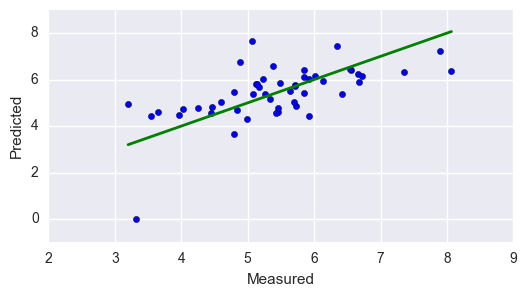

In [85]:
# Visualizing prediction errors
from sklearn.model_selection import cross_val_predict

# cross_val_predict returns an array of the same size as `Y` where each entry is a prediction obtained by cross validation
predicted = cross_val_predict(lm, X, Y, cv=10)

fig, ax = plt.subplots()
ax.scatter(Y, predicted)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'g', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


Conclusion: Overall linear regression model performs well, and cross-validation approach improves fitting. However, this model can be used only for prediction. Estimation of relative importance of features (predictors) in the prevalence of CVD is not feasible in this model.

**Random Forests Model**

Random forests, an ensemble learning method that can used for regression, operates by constructing a multitude of decision trees at training time and outputting mean prediction (regression) of the individual trees. Random forests method addresses for decision trees' habit of overfitting to their training set and provides better predictive performance.  Therefore, this method wil be used as the next step in this study. The RandomForestRegressot function provided by sklearn.essemble modules generates values representing the importance of features, which can be visualize and used in estimating potential predictive influence of each risk factor / socioeconomic characteristics.

In [86]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [87]:
# Creating a function to generate a random forests model and to evaluate its performance
def random_forest (cvd):
    """
    Conducts random forests modelling, gets model score and plots features values ranked by importance
    Uses RandomForestRegressor function
    Uses train_test_split helper function to split data into training and test sets
    :param category: string
    :return: model metrics and plot as well as values of features's relative importance and their names
    """
    # Creating a dataframe with features (predictors) to be analyzed
    df_X = df_merged.drop(df_merged.ix[:,'CHD':'Stroke'].head(0).columns, 1)
    df_X = df_X.drop(df_X.ix[:,'LocationID':'LocationDesc'].head(0).columns, 1)
    
    # Defining independent and dependent variables for regression
    X = df_X.values
    Y = df_merged[cvd].values
    
    # Random 80%/20% split to train and test data sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state = 5)
    print('Dimensionality of training and test data sets')
    print(X_train.shape)
    print(X_test.shape)
    print(Y_train.shape)
    print(Y_test.shape)
    print()
    
    # Create an instance of the random forests model
    rf = RandomForestRegressor(random_state = 1)

    # Training the model with all the 14 predictors only using the training set
    rf.fit(X_train, Y_train)

    # Checking how much of the variance in the data sets is explained by the model by determining R-squared
    print("R-squared for training data: ")
    print(rf.score(X_train,Y_train))
    print()
    print("R-squared for test data: ")
    print(rf.score(X_test,Y_test))
    print()

    # Determining mean squared error (MSE) on the data sets
    print("MSE on the training set: ")
    print(mean_squared_error(Y_train, rf.predict(X_train)))
    print()
    print("MSE on the test set: ")
    print(mean_squared_error(Y_test, rf.predict(X_test)))
    print()
    
    # Visualizing prediction errors
    predicted = rf.predict(X_test)

    fig, ax = plt.subplots()
    ax.scatter(Y_test, predicted)
    ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'g', lw=2)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
        
    # Plotting ranked features
    fimp = rf.feature_importances_
    name_list = df_X.columns
    fimp, name_list = zip(*sorted(zip(fimp, name_list)))
    plt.barh(range(len(name_list)),fimp,align='center')
    plt.yticks(range(len(name_list)),name_list)
    plt.xlabel('Relative Importance in the Random Forest')
    plt.ylabel('Features')
    plt.title('Relative Importance of Each Feature')
    plt.show()
    
    # Collecting the values of features's relative importance and their names
    return fimp, name_list

**Random forests model for CHD**

Dimensionality of training and test data sets
(40, 14)
(10, 14)
(40,)
(10,)

R-squared for training data: 
0.892676678891

R-squared for test data: 
0.707202873384

MSE on the training set: 
0.116231006232

MSE on the test set: 
0.329482160629



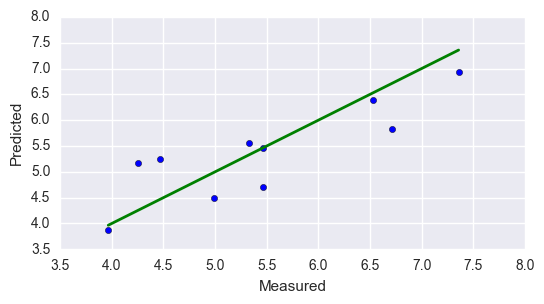

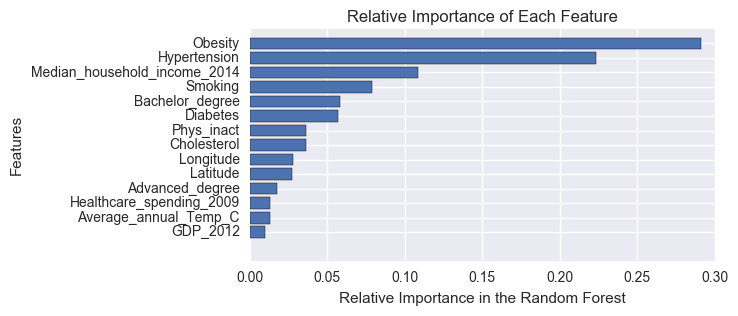

In [88]:
# Generating a random forests model and evaluating its performance
# Collecting the values of features's relative importance and their names into lists
# Target - CHD
fimp_chd, name_list_chd = random_forest('CHD')

**Measuring the performance of random forests model using cross-validation**

In [89]:
# Creating a function to generate a random forests model and to measure its performance using cross-validation
def random_forest_cross_val (cvd):
    """
    Conducts random forests modelling, gets model score and plots features values ranked by importance
    Uses RandomForestRegressor function
    Uses K-fold cross-validation iterator to split data into training and test sets
    :param category: string
    :return: model metrics and plot as well as values of features's relative importance and their names
    """
    # Creating a dataframe with features (predictors) to be analyzed
    df_X = df_merged.drop(df_merged.ix[:,'CHD':'Stroke'].head(0).columns, 1)
    df_X = df_X.drop(df_X.ix[:,'LocationID':'LocationDesc'].head(0).columns, 1)
    
    # Defining independent and dependent variables for regression
    X = df_X.values
    Y = df_merged[cvd].values
    
    # Create an instance of the Random Forests model
    rf = RandomForestRegressor(random_state = 1)

    # Fitting training data a linear regression model
    # Computing cross-validation score (R-squared) on test data
    print('Cross-validation score')
    kfold = KFold(n_splits=5)
    for train_indices, test_indices in kfold.split(X):
        rf.fit(X[train_indices], Y[train_indices])
        r2 = cross_val_score(rf, X[test_indices], Y[test_indices], scoring = 'r2')
        print(r2)
    print()

    # Checking how much of the variance in the data sets is explained by the model by determining R-squared
    print("R-squared for training data: ")
    print(rf.score(X[train_indices],Y[train_indices]))
    print()
    print("R-squared for test data: ")
    print(rf.score(X[test_indices],Y[test_indices]))
    print()
    
    # Finding the mean squared error of each training split and calculating the average value
    mse_train = 0
    mse_train = mse_train + mean_squared_error(Y[train_indices], rf.predict(X[train_indices]))
    print("Average mean squared error across all training 5 splits: ")
    print(mse_train/5)
    print()
    
    # Finding the mean squared error of each test split and calculating the average value
    mse_test = 0
    mse_test = mse_test + mean_squared_error(Y[test_indices], rf.predict(X[test_indices]))
    print("Average mean squared error across all test 5 splits: ")
    print(mse_test/5)

    # Visualizing prediction errors
    predicted = cross_val_predict(rf, X, Y, cv=10)

    fig, ax = plt.subplots()
    ax.scatter(Y, predicted)
    ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'g', lw=2)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
        
    # Plotting ranked features
    fimp = rf.feature_importances_
    name_list = df_X.columns
    fimp, name_list = zip(*sorted(zip(fimp, name_list)))
    plt.barh(range(len(name_list)),fimp,align='center')
    plt.yticks(range(len(name_list)),name_list)
    plt.xlabel('Relative Importance in the Random Forest')
    plt.ylabel('Features')
    plt.title('Relative Importance of Each Feature')
    plt.show()
    
    # Collecting the values of features's relative importance and their names
    return fimp, name_list

Cross-validation score
[-0.51289361 -4.16413789 -0.87241148]
[-1.38027041  0.78167125  0.30053895]
[ 0.22225281 -0.14496288 -2.08262092]
[ -0.35681144 -59.65068046  -9.69498229]
[ 0.21826723 -3.22834329  0.43431203]

R-squared for training data: 
0.938327511197

R-squared for test data: 
0.172607096963

Average mean squared error across all training 5 splits: 
0.0109963938003

Average mean squared error across all test 5 splits: 
0.245202922092


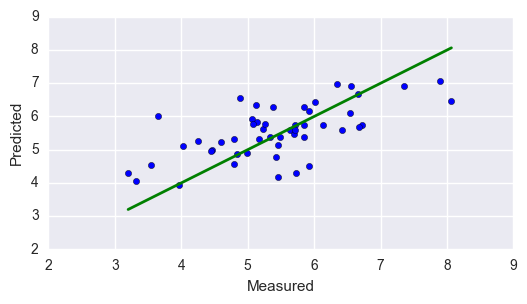

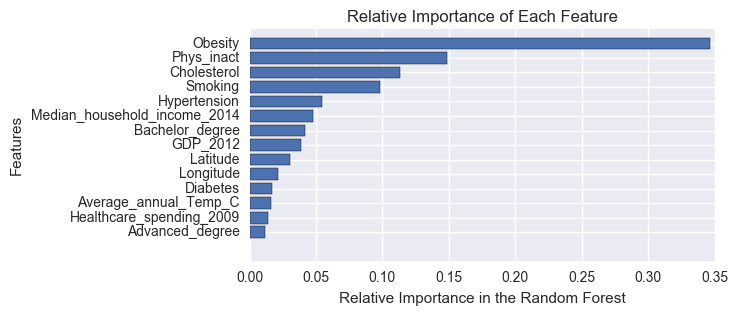

In [90]:
# Generating a random forests model and measuring its performance using cross-validation
# Collecting the values of features's relative importance and thier names
# Target - CHD
fimp_chd_cv, name_list_chd_cv = random_forest_cross_val('CHD')

The evaluation of the random forests model for CHD shows that it performs well on the training data and test data sets. Cross-validation improves training performance (R-squared: 0.94 vs 0.89) of the random forests model, but significantly decreases its predictive power on test data sets (0.71 vs 0.17), despite lower MSE (0.33 vs 0.25). The two evaluation approaches will be used in random forests modelling of the prevalence of other CVD - heart attack and stroke, and the results will be compared. 

**Random forests model for heart attack**

Dimensionality of training and test data sets
(40, 14)
(10, 14)
(40,)
(10,)

R-squared for training data: 
0.883026363145

R-squared for test data: 
0.61688027203

MSE on the training set: 
0.128987185015

MSE on the test set: 
0.261911588029



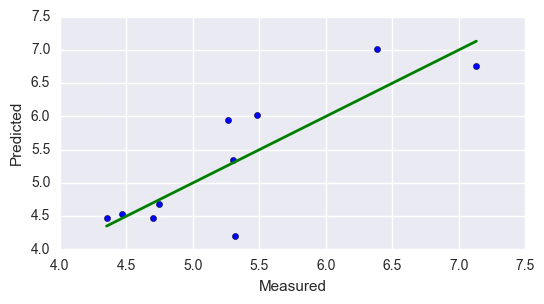

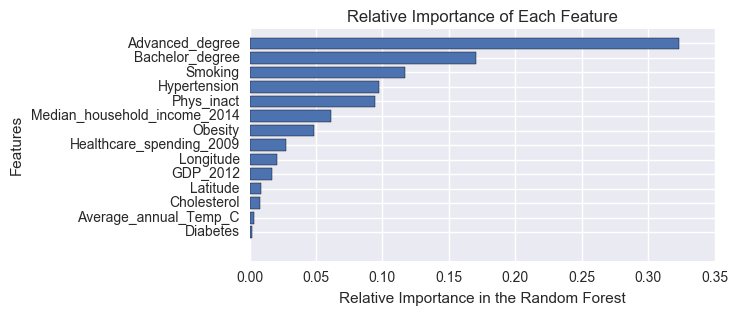

In [91]:
# Generating a random forests model and evaluating its performance
# Collecting the values of features's relative importance and their names into lists
# Target - Heart attack
fimp_ha, name_list_ha = random_forest('Heart_attack')

Cross-validation score
[-0.64814704 -8.56161449 -1.27904158]
[-1.82212284  0.79413028  0.1440208 ]
[ 0.24008278 -1.12673876  0.29180525]
[-1.76611515  0.11996407 -0.16907725]
[-0.0017599  -0.06153179  0.58818741]

R-squared for training data: 
0.942203312165

R-squared for test data: 
0.384391661921

Average mean squared error across all training 5 splits: 
0.00881745008023

Average mean squared error across all test 5 splits: 
0.235487867901


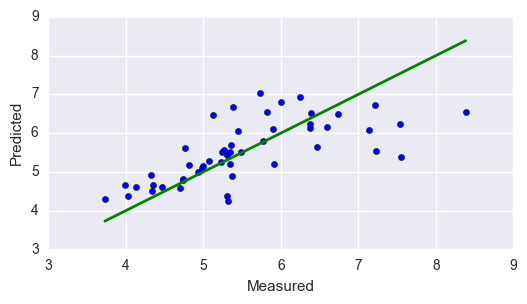

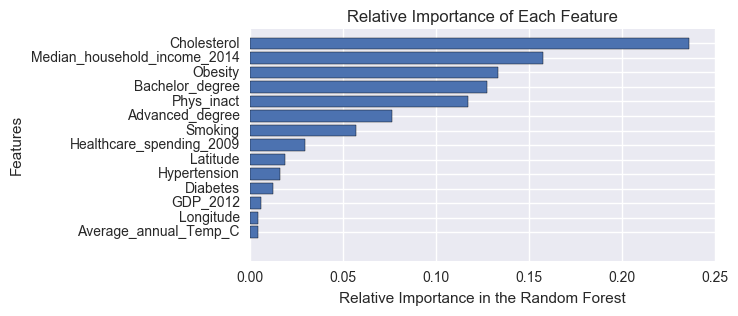

In [92]:
# Generating a random forest models and measuring its performance using cross-validation
# Collecting the values of features's relative importance and their names into lists
# Target - Heart attack
fimp_ha_cv, name_list_ha_cv = random_forest_cross_val('Heart_attack')

**Random forests model for stroke**

Dimensionality of training and test data sets
(40, 14)
(10, 14)
(40,)
(10,)

R-squared for training data: 
0.896494936695

R-squared for test data: 
0.682047543479

MSE on the training set: 
0.0520358452117

MSE on the test set: 
0.277858917796



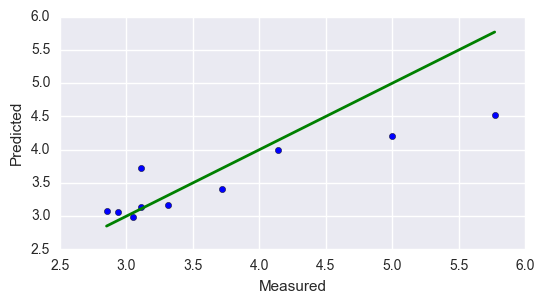

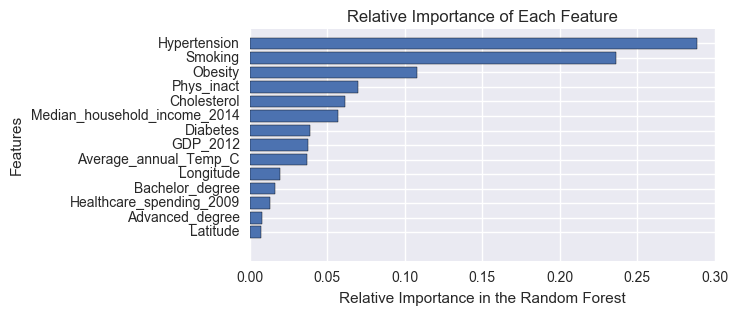

In [93]:
# Generating a random forest model and evaluating its performance
# Collecting the values of features's relative importance and their names into lists
# Target - Stroke
fimp_stroke, name_list_stroke = random_forest('Stroke')

Cross-validation score
[ -0.84627409 -10.62082718  -1.69576351]
[-0.07710709  0.60539738  0.43892539]
[ 0.1851643  -0.13521974  0.9235215 ]
[ -1.19218327 -22.29837496  -0.39854563]
[ 0.07289592 -2.75983649  0.15982241]

R-squared for training data: 
0.932505595803

R-squared for test data: 
-0.551225933122

Average mean squared error across all training 5 splits: 
0.00876901147235

Average mean squared error across all test 5 splits: 
0.0820431510771


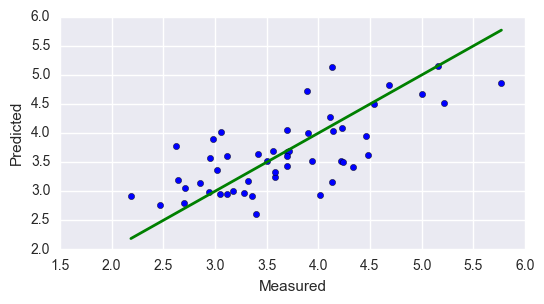

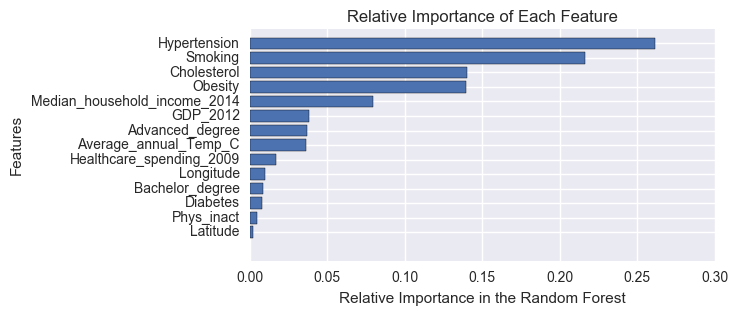

In [94]:
# Generating a random forest model and measuring its performance using cross-validation
# Collecting the values of features's relative importance and their names into lists
# Target - Stroke
fimp_stroke_cv, name_list_stroke_cv = random_forest_cross_val('Stroke')

The analysis shows that the relative importance of features, which are risk factors and socioeconomc characteristics of U.S. states, varies for different CVD. This observation is important for the prevention of CVD, optimization of healthcare spending, and more accurate estimation of future risks of CVD. Cross-validation improves the performance of the random forest model, which can be estimated by an decrease in MSE. Decreased R-squared value for the model performance on test data can be explained by higher level of variability due to smaller (4:1) sample size. It should not affect the interpretation of the results and relative importance of the features. However, low R-squared values are problematic when precise prediction is required. An increase in test sample size should overcome this issue.

Plotting relative importance of risk factors and socioeconomic characteristics for all three CVD without and with cross-validation is very helpfull in the analysis of different aspects related to specific CVD.

In [95]:
# Putting together collected values of features's relative importance and their names for three CVD
# Creating a dataframe to be used for visualization
df10_chd = pd.DataFrame({'CHD':fimp_chd, 'Feature':name_list_chd}).sort_values(by='Feature').reset_index().reset_index().drop('index', 1)
df10_ha = pd.DataFrame({'HA':fimp_ha, 'Feature':name_list_ha}).sort_values(by='Feature').reset_index().reset_index().drop('Feature', 1).drop('index', 1)
df10_stroke = pd.DataFrame({'Stroke':fimp_stroke, 'Feature':name_list_stroke}).sort_values(by='Feature').reset_index().reset_index().drop('Feature', 1).drop('index', 1)
df10_merged = pd.merge(df10_ha, df10_stroke, on='level_0')
df10_merged_all = pd.merge(df10_merged, df10_chd, on='level_0')
df10_merged_all = df10_merged_all.drop('level_0', 1)
df10_merged_all.head(3)

,HA,Stroke,CHD,Feature
0,0.323319,0.008152,0.017627,Advanced_degree
1,0.003534,0.037389,0.013371,Average_annual_Temp_C
2,0.170329,0.016328,0.058178,Bachelor_degree


In [96]:
# Putting together collected values of features's relative importance and their names for three CVD
# Creating a dataframe to be used for visualization
df10_chd_cv = pd.DataFrame({'CHD':fimp_chd_cv, 'Feature':name_list_chd_cv}).sort_values(by='Feature').reset_index().reset_index().drop('index', 1)
df10_ha_cv = pd.DataFrame({'HA':fimp_ha_cv, 'Feature':name_list_ha_cv}).sort_values(by='Feature').reset_index().reset_index().drop('Feature', 1).drop('index', 1)
df10_stroke_cv = pd.DataFrame({'Stroke':fimp_stroke_cv, 'Feature':name_list_stroke_cv}).sort_values(by='Feature').reset_index().reset_index().drop('Feature', 1).drop('index', 1)
df10_merged_cv = pd.merge(df10_ha_cv, df10_stroke_cv, on='level_0')
df10_merged_all_cv = pd.merge(df10_merged_cv, df10_chd_cv, on='level_0')
df10_merged_all_cv = df10_merged_all_cv.drop('level_0', 1)
df10_merged_all_cv.head(3)

,HA,Stroke,CHD,Feature
0,0.076669,0.037254,0.011760,Advanced_degree
1,0.004655,0.036129,0.016274,Average_annual_Temp_C
2,0.127667,0.008550,0.042094,Bachelor_degree


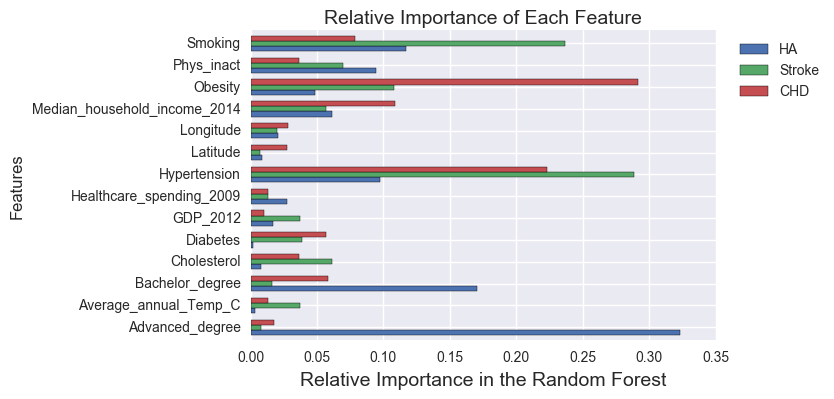

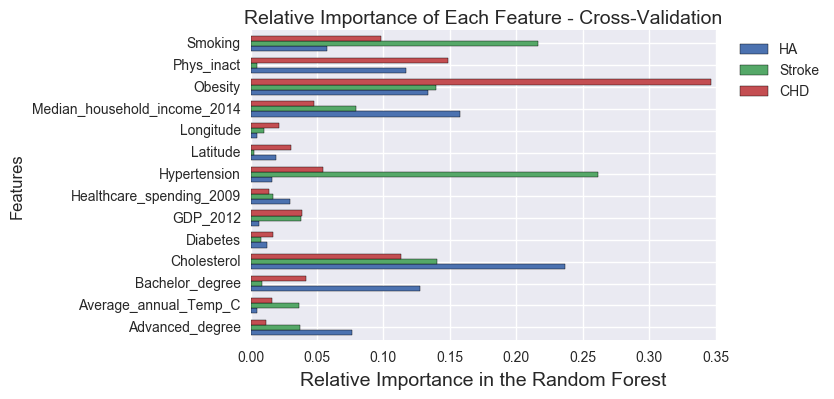

In [97]:
# Plotting relative importance of each feature for all three CVD
feature_list = df10_merged_all.Feature.tolist()
df10_barh = df10_merged_all.drop('Feature', 1)
ax = df10_barh.plot(kind='barh', figsize=(6,4), width=0.7)
ax.set_yticklabels(feature_list)
ax.set_title('Relative Importance of Each Feature', fontsize=14)
ax.set_ylabel('Features', fontsize=12)
ax.set_xlabel('Relative Importance in the Random Forest', fontsize=14)
ax.legend(bbox_to_anchor=(1.25, 1))
plt.show()

# Plotting relative importance of each feature for all three CVD (Cross-Validation)
feature_list_cv = df10_merged_all_cv.Feature.tolist()
df10_barh_cv = df10_merged_all_cv.drop('Feature', 1)
ax1 = df10_barh_cv.plot(kind='barh', figsize=(6,4), width=0.7)
ax1.set_yticklabels(feature_list)
ax1.set_title('Relative Importance of Each Feature - Cross-Validation', fontsize=14)
ax1.set_ylabel('Features', fontsize=12)
ax1.set_xlabel('Relative Importance in the Random Forest', fontsize=14)
ax1.legend(bbox_to_anchor=(1.25, 1))
plt.show()

Conclusion: According to the random forests model, relative importance of risk factors and socioeconomc characteristics of U.S. states, varies for different CVD. Most important are traditional risk factors, which is not surprising. Obsesity, physical inactivity, blood level of cholesterol, and smoking are most important for the prevalence of CHD. Less important for CHD are socioeconomic factors. Most important among them are household income, education (Bachelor's degree), and GDP.

Stroke has a slightly different profile. Hypertension, smoking, obesity and cholesterol followed by household income are most important factors for prevalnce of this CVD. Other factors are much less significant.

The role of socioeconomic factors is much more important for the prevalence of heart attack. The rank of importance is the following: cholesterol, household income, obesity, education (Bachelor's degree), physical inactivity, and education (advanced degree).

Overall diabetes, healthcare spending, geolocation, and average temperature are most insignifacant factors for the prevalence of all CVD.

## Unsupervised Learning - Cluster Analysis

In further analysis, clusters of U.S. states with similar prevalence of risk factors and socioeconomic characteristics will be determined using unsupervised learning, which uses unlabeled input data. Then, variation in the prevalence of all three CVD in different clusters will be analyzed.

**K-means**

First, K-means algorithm, one of the simplest unsupervised learning algorithms, will be used to resove the clustering problem.

In [98]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from scipy.spatial.distance import cdist

In [99]:
# Creating a dataframe with features (predictors) to be analyzed - cluster variables
df_X = df_merged.drop(df_merged.ix[:,'CHD':'Stroke'].columns, 1)
df_X = df_X.drop(df_X.ix[:,'LocationID':'LocationDesc'].columns, 1)

In [100]:
# Creating a copy of the predictors dataframe
# Standardizing clustering variables to have mean=0 and sd=1
clustervar = df_X.copy()
clustervar.loc[:] = scale(clustervar.loc[:].astype('float64'))

** Determining number of clusters**

K-means algorithm uses a predetermined number of clusters (k), which are subsets of representative examples, so called "examplars", to partition the data. This is a limitation of this algorithm, since k-centers clustering is quite sensitive to the initial selection of exemplars, so it is usually rerun many times with different initializations in an attempt to find a good solution.

The Elbow Method will used in this analysis to determine the number clusters. Average distance from cluster centers will be plotted as a function of the number of clusters, and a number of clusters will be chosen based on the assumption that adding another cluster doesn't give much better modelling of the data.

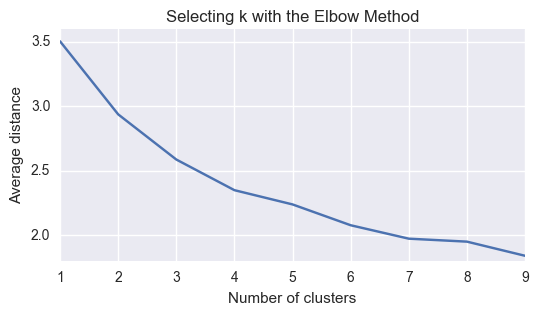

In [101]:
# Running K-means cluster analysis for 1-9 clusters
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clustervar)
    clusassign=model.predict(clustervar)
    meandist.append(sum(np.min(cdist(clustervar, model.cluster_centers_, 'euclidean'), axis=1)) / clustervar.shape[0])
    
# Plotting average distance from observations to the cluster centroid
# Using the Elbow Method to identify number of clusters to choose
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.show()

This method does not clearly determine the number of clusters in the data. The plotted dependence is not stable and often varies. Based on this method, from 4 to 6 clusters can be identified. Considering the number of states (50), it seems unlikely that the number of clusters is higher than 6. 4-cluster model will be built, and the results will be analyzed and compared with those obtained with a different method.

In [102]:
# Generating a 4-cluster model
model4 = KMeans(n_clusters=4)
model4.fit(clustervar)
clusassign = model4.predict(clustervar)

To visualize clusters and to determine if they overlap, it is necessary to graph them. However, since there are 14 clustering variables, it is not possible to plot all 14 dimensions. Therefore, principal component analysis (PCA) will be used in this study to produces a low-dimensional representation of the input data by transforming possibly correlated variables into a set of linearly uncorrelated variables (principal components). Each of the components are ordered by proportion of variance that each is able to explain from the data, so the first principal component accounts for the largest amount of variance, the second principal component the next largest, and so on.

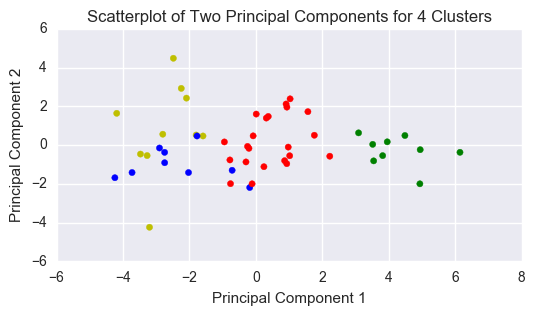

In [103]:
# Conducting PCA (2 components are kept)
# Plotting first 2 principal components
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clustervar)

colors = ['b', 'g', 'r', 'y']
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], color=[colors[label] for label in clusassign], label=clusassign)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot of Two Principal Components for 4 Clusters')
plt.show()

The 2D plot with only 2 components shows no clear separation between 2 of 4 clusters. Therefore, 3D plot will be used to plot 3 principal components.

Rotation - 100 degrees


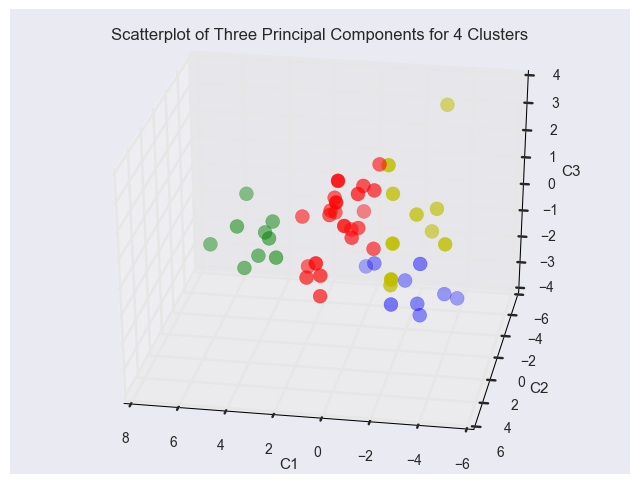


Rotation - 260 degrees


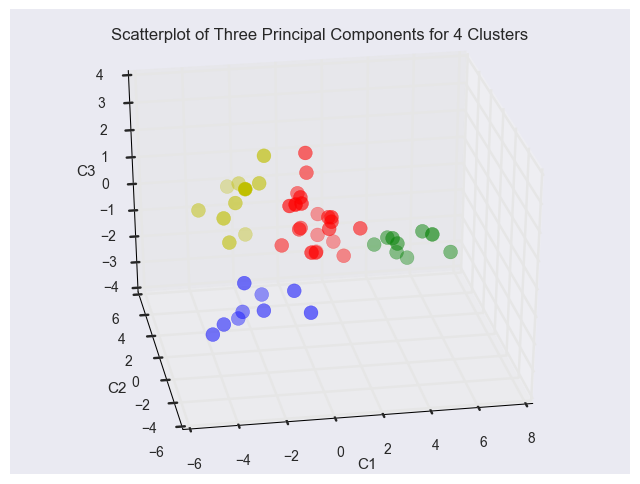

In [104]:
# Conducting PCA (3 components are kept)
# Plotting first 3 principal components (3D plot with different rotation degrees)
from mpl_toolkits.mplot3d import Axes3D

pca_3 = PCA(3)
plot_columns3 = pca_3.fit_transform(clustervar)

xs=plot_columns3[:,0]
ys=plot_columns3[:,1]
zs=plot_columns3[:,2]
colors = ['b', 'g', 'r', 'y']

print('Rotation - 100 degrees')
fig = plt.figure(figsize=(8,6))                     
ax = fig.add_subplot(111, projection='3d') 
ax.view_init(azim=100)
#print(ax.azim)
ax.scatter(xs, ys, zs, color=[colors[label] for label in clusassign], label=clusassign, s=100, zdir='z')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')
plt.title('Scatterplot of Three Principal Components for 4 Clusters')
plt.show()
print()

print('Rotation - 260 degrees')
fig = plt.figure(figsize=(8,6))                     
ax = fig.add_subplot(111, projection='3d') 
ax.view_init(azim=260)
ax.scatter(xs, ys, zs, color=[colors[label] for label in clusassign], label=clusassign, s=100, zdir='z')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')
plt.title('Scatterplot of Three Principal Components for 4 Clusters')
plt.show()

In [105]:
# Getting the proportion of variance that each component explains
print(pca_3.explained_variance_ratio_)
print(sum(pca_3.explained_variance_ratio_))

[ 0.47713039  0.16269049  0.14842368]
0.788244550509


The 3D plot with 3 components clearly shows 4 clusters. Firts 3 components explain about 79% of variance from the data. In the next step, U.S. states with corresponding prevalence of CVD and RF will be shown. For K-means method, the data for only one of CVD (CHD) will be shown.

**Desribing clusters**

In [106]:
# Merging cluster labels with standardized clustering variables
clustervar.reset_index(level=0, inplace=True)
cluslist=clustervar['index'].tolist()
labels=model4.labels_.tolist()

newlist=dict(zip(cluslist, labels))
newclus = pd.DataFrame.from_dict(newlist, orient='index')
newclus.columns = ['cluster']
newclus.reset_index(level=0, inplace=True)

merged = pd.merge(clustervar, newclus, on='index')
merged.head(3)

,index,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude,Cholesterol,Diabetes,Hypertension,Obesity,Phys_inact,Smoking,cluster
0,0,-1.199013,-0.752927,-1.128479,-0.798281,-1.101742,1.260186,-1.091670,0.374973,2.076632,2.467571,1.703113,0.770304,1.059615,0.763055,1
1,1,2.461891,2.324460,-0.207188,0.095607,1.073047,-2.943223,3.995189,-2.859885,-0.160117,-1.966426,0.459466,0.342896,-0.763285,0.806559,3
2,2,-0.868081,-1.655655,-0.309554,-0.215310,-0.491667,0.967412,-0.769749,-0.955821,1.051190,0.607914,-0.216657,-0.428659,-0.162282,-0.819399,2


In [107]:
# Adding states names and CHD data
chd_data = df_merged[['LocationDesc', 'CHD']]
chd_data.reset_index(level=0, inplace=True)
merged_all = pd.merge(chd_data, merged, on='index')
merged_all.head(3)

,index,LocationDesc,CHD,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude,Cholesterol,Diabetes,Hypertension,Obesity,Phys_inact,Smoking,cluster
0,0,Alabama,6.666667,-1.199013,-0.752927,-1.128479,-0.798281,-1.101742,1.260186,-1.091670,0.374973,2.076632,2.467571,1.703113,0.770304,1.059615,0.763055,1
1,1,Alaska,5.066667,2.461891,2.324460,-0.207188,0.095607,1.073047,-2.943223,3.995189,-2.859885,-0.160117,-1.966426,0.459466,0.342896,-0.763285,0.806559,3
2,2,Arizona,5.460000,-0.868081,-1.655655,-0.309554,-0.215310,-0.491667,0.967412,-0.769749,-0.955821,1.051190,0.607914,-0.216657,-0.428659,-0.162282,-0.819399,2


In [108]:
# Estimating statistical significance of the proposed clusters based on the prevalence of CHD using OLS method
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

sub1 = merged_all[['CHD', 'cluster']].dropna()
chdmod = smf.ols(formula='CHD ~ C(cluster)', data = sub1).fit()
print(chdmod.summary())

                            OLS Regression Results                            
Dep. Variable:                    CHD   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     13.37
Date:                Sat, 11 Mar 2017   Prob (F-statistic):           2.09e-06
Time:                        12:00:57   Log-Likelihood:                -57.459
No. Observations:                  50   AIC:                             122.9
Df Residuals:                      46   BIC:                             130.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           5.1012      0.265     

The analysis shows that the 4-cluster model is statically significant at the 0.1% level based on the prevalence of CHD. Tukey's range test will be used further to estimate the difference in the prevalence of CHD between all clusters.

In [109]:
# Getting CHD mean and std values for each cluster
print('mean for CHD by cluster')
m1 = sub1.groupby('cluster').mean()
print(m1)
print('')
print('standard deviation for CHD by cluster')
m2 = sub1.groupby('cluster').std()
print(m2)
print('')

# Running Tukey's range test
mc1 = multi.MultiComparison(sub1['CHD'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

mean for CHD by cluster
              CHD
cluster          
0        5.101243
1        6.740741
2        5.466753
3        4.483369

standard deviation for CHD by cluster
              CHD
cluster          
0        0.695317
1        0.890668
2        0.706503
3        0.969303

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1     1.6395   0.6391  2.6399  True 
  0      2     0.3655  -0.4742  1.2052 False 
  0      3    -0.6179  -1.5929  0.3572 False 
  1      2     -1.274  -2.1137 -0.4343  True 
  1      3    -2.2574  -3.2324 -1.2823  True 
  2      3    -0.9834  -1.7927 -0.1741  True 
---------------------------------------------


The analysis shows that the prevalence of CHD is not statistical different between all clusters.

**Visualizing states clusters on U.S. map**

In [110]:
# Creating a list of state names for each cluster
cluster0 = merged_all[merged_all.cluster == 0]
print('cluster 0: %d' % len(cluster0))
cluster1 = merged_all[merged_all.cluster == 1]
print('cluster 1: %d' % len(cluster1))
cluster2 = merged_all[merged_all.cluster == 2]
print('cluster 2: %d' % len(cluster2))
cluster3 = merged_all[merged_all.cluster == 3]
print('cluster 3: %d' % len(cluster3))

cluster 0: 9
cluster 1: 9
cluster 2: 22
cluster 3: 10


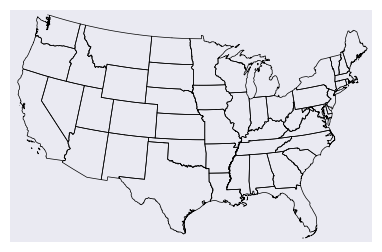

In [111]:
#  Creating a U.S. map object (Alaska and Hawaii are not included)
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# Loading the shapefile
map_US = map.readshapefile('st99_d00', name='states', drawbounds=True)

In [112]:
# Creating a function to get a list of U.S. state indexes
def clus_state_ind_list (cluster):
    """
    Generates a list of U.S. state indexes
    :param args: dataframe
    :return: list of indexes
    """
    
    state_list = cluster['LocationDesc'].tolist()
    state_list1 = [el.replace('\xa0', '') for el in state_list]
        
    clus_ind_list = []
    state_names = []  
    for state in state_list1:
        if state == 'Wisconsin': # fixing Basemap/shapefile bug - code 99 is not mapped
            clus_ind_list.append(101)
        elif state == 'Michigan': # fixing Basemap/shapefile bug - code 95 is not mapped
            clus_ind_list.append(106)
        else:
            for shape_dict in map.states_info:
                state_names.append(shape_dict['NAME'])
            clus_ind_list.append(state_names.index(state))
    return clus_ind_list

In [113]:
# Getting state indexes for each cluster into a list
c0 = clus_state_ind_list(cluster0)
c1 = clus_state_ind_list(cluster1)
c2 = clus_state_ind_list(cluster2)
c3 = clus_state_ind_list(cluster3)

# Creating a list of the indexlists
clusters_list = [c0, c1, c2, c3]

In [114]:
# Creating a function to visualize states clusters on U.S. map
def clus_state_map(clus_list):
    """
    Filling state polygons by cluster color
    :param args: list (max = 4 elements)
    :return: U.S. map of clusters 
    """
    # create the map
    map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

    # load the shapefile, use the name 'states'
    map.readshapefile('st99_d00', name='states', drawbounds=True)
    
    # collect the state names from the shapefile attributes so we can
    # look up the shape obect for a state by it's name
    ax1 = plt.gca() # get current axes instance
    colors = ['greenyellow', 'silver', 'coral', 'deepskyblue']
    ncolor = 0
    clusters = [0, 1, 2, 3]
    ncluster = 0

    for clus in clus_list:
        for ind in clus:
            seg = map.states[ind]
            poly = Polygon(seg, facecolor=colors[ncolor],edgecolor='red')
            ax1.add_patch(poly)
        print('cluster %d color: %s' % (clusters[ncluster], colors[ncolor]))
        ncolor += 1
        ncluster += 1

cluster 0 color: greenyellow
cluster 1 color: silver
cluster 2 color: coral
cluster 3 color: deepskyblue


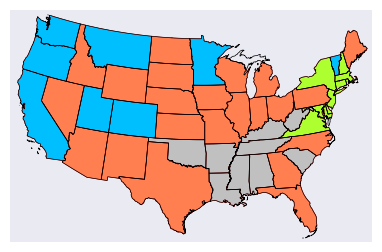

In [115]:
# Visualizing states clusters on U.S. map
clus_state_map(clusters_list)

In [116]:
# Calculating clustering variable means by cluster
clusgrp_chd_mean = merged_all.groupby('cluster').mean()
clusgrp_chd1_mean = clusgrp_chd_mean.reset_index()
clusgrp_chd1_mean = clusgrp_chd1_mean.drop('index', 1)
clusgrp_chd1_mean

,cluster,CHD,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude,Cholesterol,Diabetes,Hypertension,Obesity,Phys_inact,Smoking
0,0,5.101243,1.035334,1.140788,1.341946,1.598375,1.358418,-0.182775,0.187608,1.030808,0.361551,-0.364379,-0.338978,-0.776537,0.022108,-0.664656
1,1,6.740741,-1.023699,-0.407075,-1.296814,-0.962376,-1.191385,0.934881,-0.781807,0.310067,1.296889,1.272482,1.794002,1.227203,1.398755,1.390236
2,2,5.466753,-0.185764,-0.230986,-0.317929,-0.409634,-0.359168,-0.063954,-0.002855,-0.008115,-0.180870,0.207989,-0.226848,0.244831,-0.009854,0.045071
3,3,4.483369,0.398209,-0.152173,0.658825,0.328795,0.639841,-0.536196,0.541060,-1.188934,-1.094681,-1.274869,-0.810455,-0.944227,-1.257098,-0.752178


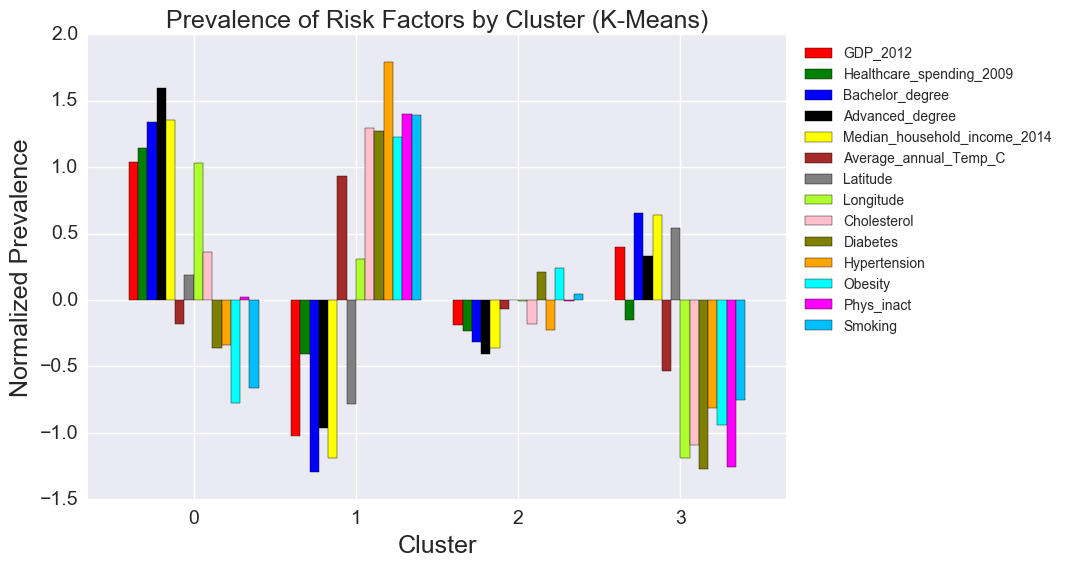

In [117]:
# Plotting prevalence of RF by cluster
clusgrp_chd1_bar = clusgrp_chd1_mean.drop(clusgrp_chd1_mean.ix[:,'cluster':'CHD'].columns, 1)
colors = ['r', 'g', 'b', 'k', 'yellow', 'brown', 'grey', 'greenyellow', 'pink', 'olive', 'orange', 'cyan', 'magenta', 'deepskyblue']
ax = clusgrp_chd1_bar.plot(kind='bar', figsize=(9, 6), legend=True, width = 0.8, fontsize=14, color=colors)
ax.set_title('Prevalence of Risk Factors by Cluster (K-Means)', fontsize=18)
ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel("Normalized Prevalence", fontsize=18)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
ax.legend(bbox_to_anchor=(1.4, 1))
plt.show()

The analysis reveals the difference in RF profiles of the clusters. The West cluster, which includes the West Coast states, Hawaii, and Alaska as well as Montana, Minnesota, Vermont, Utah, and Colorado, has overall lowest prevalence of RF among the clusters. It is also characterized by lowest prevalence of CHD. At the same time, the values of socioeconmic characteristics are lower in comparison with the North-East cluster, which includes Virginia, New York, Massachusetts, Connecticut, New Jersey, Delaware, Maryland, New Hampshire and a few other states. The overall prevalence of RF in this cluster is ranked second after the West cluster, as that of CHD does. The Central cluster is ranked third based on the overall prevalence of CHD, RF, and socioeconomic characteristics. The worst based on the metrics is the South-East cluster.

This results are in a good agreement with the previously made conclusion on the importance of traditional risk factors in prevalence of CVD. The socioeconomic characteristics are also important, but not as important as RF. Also, the relationship betwee CVD (CHD) and socioeconomic characteristics is more complex than that for RF. The results are also in agreement with geographical clusters of U.S. states, which supports the proposed K-means clustering. 

**Affinity Propagation**

Variation in the number of states in clusters and estimated number of clusters are limitations of K-means method. Therefore, the performance of the K-mean model will be compared with that generated by affinity propagation clustering algorithm. This relatively new algorithm was introduced by a research group at the University of Toronto (Frey B. and Dueck D. (2007) Clustering by passing messages between data points. Science, v. 315). It takes as input measures of similarity between pairs of data points. Real-valued messages are exchanged between data points until a high-quality set of exemplars and corresponding clusters gradually emerges. Affinity propagation finds clusters with much lower error than other methods.

**Affinity propagation model for CHD**

In [118]:
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler

In [119]:
# Defining independent and dependent variables
X = df_X.values       
labels_true = df_merged['CHD'].values
# Normalizing the X dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

In [120]:
# Generating an affinity propagation model and estimating its performance for CHD
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 4
Homogeneity: 0.328
Completeness: 0.978
V-measure: 0.492
Adjusted Rand Index: 0.010
Adjusted Mutual Information: 0.019
Silhouette Coefficient: 0.239


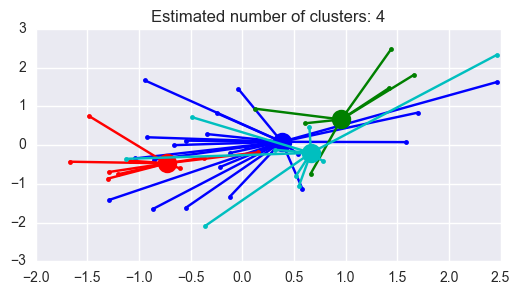

In [121]:
# Visualizing estimated clusters and cluster centers
from itertools import cycle

plt.figure()
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Rotation - 100 degrees


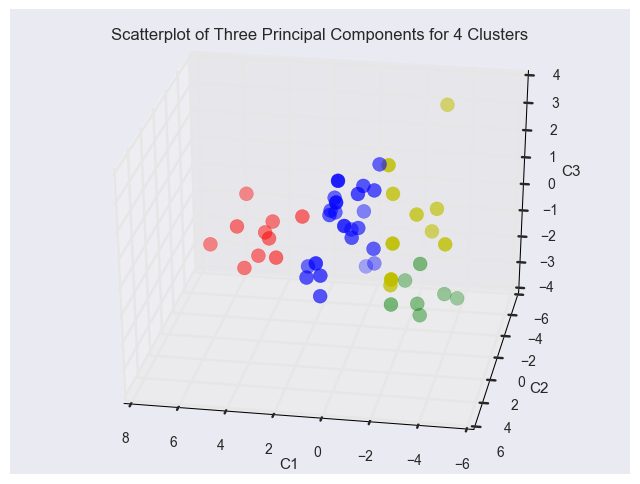


Rotation - 260 degrees


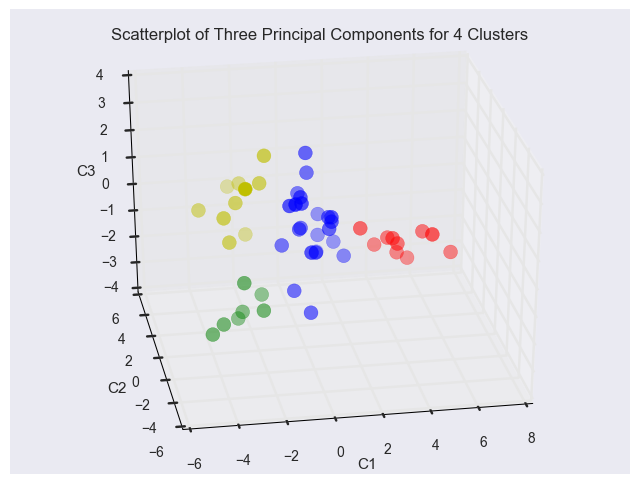

In [122]:
# Conducting PCA (3 components are kept)
# Plotting first 3 principal components (3D plot with different rotation degrees)

pca1_3 = PCA(3)
plot_columns3 = pca1_3.fit_transform(X)
xs=plot_columns3[:,0]
ys=plot_columns3[:,1]
zs=plot_columns3[:,2]
colors = ['b', 'g', 'r', 'y']

print('Rotation - 100 degrees')
fig = plt.figure(figsize=(8,6))                     
ax = fig.add_subplot(111, projection='3d') 
ax.view_init(azim=100)
#print(ax.azim)
ax.scatter(xs, ys, zs, color=[colors[label] for label in labels], label=labels, s=100, zdir='z')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')
plt.title('Scatterplot of Three Principal Components for 4 Clusters')
plt.show()
print()

print('Rotation - 260 degrees')
fig = plt.figure(figsize=(8,6))                     
ax = fig.add_subplot(111, projection='3d') 
ax.view_init(azim=260)
ax.scatter(xs, ys, zs, color=[colors[label] for label in labels], label=labels, s=100, zdir='z')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')
plt.title('Scatterplot of Three Principal Components for 4 Clusters')
plt.show()

The affinity propagation model proposes 4 clusters. The obtained metrics scores for CHD (particularly homogeneity and silhouette coefficient) implies that the clusters are clearly identified, but there is certain degree of overlap between them. 3D vizulalization of the PCA results shows that the clusters determined by the affinity propagation algorithm are similar with those identified by the K-means model, though some data points belongs to different clusters.

**Affinity propagation model for heart attack**

In [123]:
# Defining independent and dependent variables for regression
X = df_X.values       
labels_true = df_merged['Heart_attack'].values
# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

In [124]:
# Generating an affinity propagation model and estimating its performance for heart attack
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 4
Homogeneity: 0.321
Completeness: 0.978
V-measure: 0.484
Adjusted Rand Index: -0.002
Adjusted Mutual Information: -0.003
Silhouette Coefficient: 0.239


**Affinity propagation model for stroke**

In [125]:
# Defining independent and dependent variables for regression
X = df_X.values       
labels_true = df_merged['Stroke'].values
# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

In [126]:
# Generating an affinity propagation model and estimating its performance for stroke
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 4
Homogeneity: 0.317
Completeness: 0.957
V-measure: 0.476
Adjusted Rand Index: -0.003
Adjusted Mutual Information: -0.006
Silhouette Coefficient: 0.239


The metrics scores for heart attack and stroke are not significantly different form ones for CHD.

**Describing clusters**

In [127]:
# Merging cluster labels with standardized clustering variables
cluslist1=clustervar['index'].tolist()
labels_list = labels.tolist()

newlist1=dict(zip(cluslist1, labels_list))
newclus1 = pd.DataFrame.from_dict(newlist1, orient='index')
newclus1.columns = ['cluster']
newclus1.reset_index(level=0, inplace=True)
merged1 = pd.merge(clustervar, newclus1, on='index')

# Adding states names and CHD data
cvd_data = df_merged[['LocationDesc', 'CHD', 'Heart_attack', 'Stroke']]
cvd_data.reset_index(level=0, inplace=True)
merged1_all = pd.merge(cvd_data, merged1, on='index')
merged1_all.head(3)

,index,LocationDesc,CHD,Heart_attack,Stroke,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude,Cholesterol,Diabetes,Hypertension,Obesity,Phys_inact,Smoking,cluster
0,0,Alabama,6.666667,7.216667,5.214286,-1.199013,-0.752927,-1.128479,-0.798281,-1.101742,1.260186,-1.091670,0.374973,2.076632,2.467571,1.703113,0.770304,1.059615,0.763055,2
1,1,Alaska,5.066667,4.933333,3.700000,2.461891,2.324460,-0.207188,0.095607,1.073047,-2.943223,3.995189,-2.859885,-0.160117,-1.966426,0.459466,0.342896,-0.763285,0.806559,3
2,2,Arizona,5.460000,5.300000,3.720000,-0.868081,-1.655655,-0.309554,-0.215310,-0.491667,0.967412,-0.769749,-0.955821,1.051190,0.607914,-0.216657,-0.428659,-0.162282,-0.819399,0


**Visualizing states clusters on U.S. map**

In [128]:
# Creating a list of state names for each cluster
cluster0 = merged1_all[merged1_all.cluster == 0]
print('cluster 0: %d' % len(cluster0))
cluster1 = merged1_all[merged1_all.cluster == 1]
print('cluster 1: %d' % len(cluster1))
cluster2 = merged1_all[merged1_all.cluster == 2]
print('cluster 2: %d' % len(cluster2))
cluster3 = merged1_all[merged1_all.cluster == 3]
print('cluster 3: %d' % len(cluster3))

cluster 0: 23
cluster 1: 7
cluster 2: 10
cluster 3: 10


In [129]:
# Getting state indexes for each cluster into a list
c0 = clus_state_ind_list(cluster0)
c1 = clus_state_ind_list(cluster1)
c2 = clus_state_ind_list(cluster2)
c3 = clus_state_ind_list(cluster3)

# Creating a list of the index lists
clusters_list = [c0, c1, c2, c3]

cluster 0 color: greenyellow
cluster 1 color: silver
cluster 2 color: coral
cluster 3 color: deepskyblue


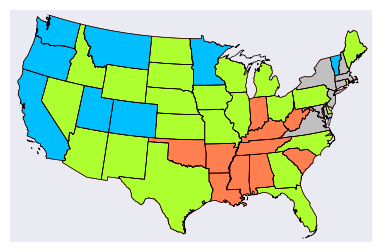

In [130]:
# Visualizing states clusters on U.S. map
clus_state_map(clusters_list)

In [131]:
# Calculating clustering variable means by cluster
clusgrp_cvd_mean = merged1_all.groupby('cluster').mean()
clusgrp_cvd_mean = clusgrp_cvd_mean.reset_index()
clusgrp_cvd_mean = clusgrp_cvd_mean.drop('index', 1)
clusgrp_cvd_mean

,cluster,CHD,Heart_attack,Stroke,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude,Cholesterol,Diabetes,Hypertension,Obesity,Phys_inact,Smoking
0,0,5.519545,5.691437,3.626253,-0.055926,-0.073270,-0.225881,-0.298109,-0.272523,-0.051845,0.005847,0.067667,-0.113105,0.147832,-0.174771,0.211670,-0.034890,0.006443
1,1,4.906361,4.713061,3.000102,0.984167,1.028328,1.611996,1.861174,1.587853,-0.260450,0.211709,1.020274,0.263991,-0.430733,-0.578616,-1.116030,-0.092459,-0.822620
2,2,6.555238,6.719524,4.673631,-0.958497,-0.399136,-1.267696,-0.945966,-1.124536,0.837754,-0.702704,0.319109,1.170029,1.236368,1.617459,1.238607,1.402066,1.313192
3,3,4.483369,4.587845,3.256016,0.398209,-0.152173,0.658825,0.328795,0.639841,-0.536196,0.541060,-1.188934,-1.094681,-1.274869,-0.810455,-0.944227,-1.257098,-0.752178


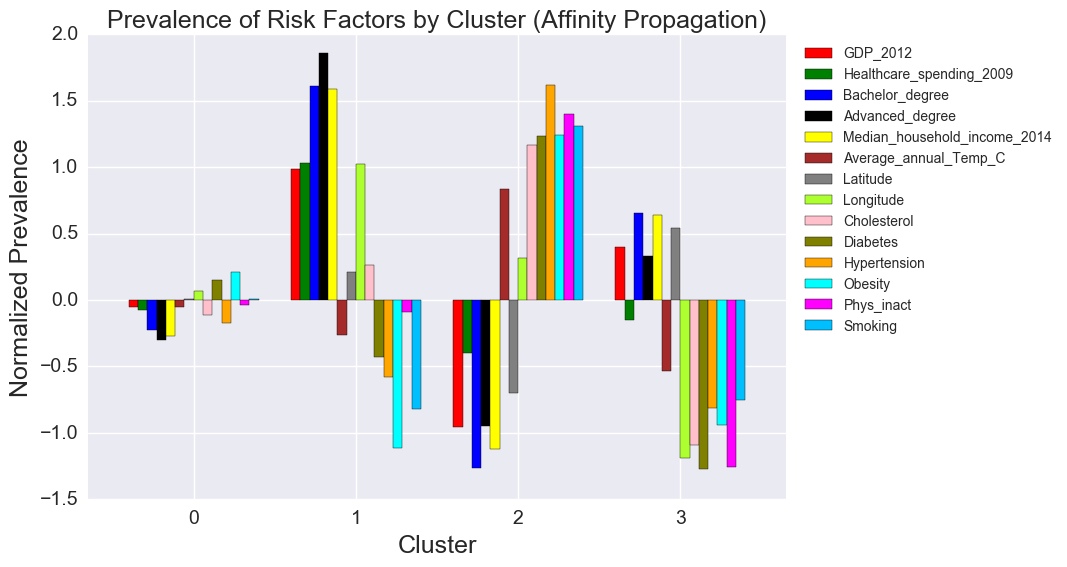

In [132]:
# Plotting prevalence of RF by cluster
clusgrp_rf_bar = clusgrp_cvd_mean.drop(clusgrp_cvd_mean.ix[:,'cluster':'Stroke'].columns, 1)
colors = ['r', 'g', 'b', 'k', 'yellow', 'brown', 'grey', 'greenyellow', 'pink', 'olive', 'orange', 'cyan', 'magenta', 'deepskyblue']
ax = clusgrp_rf_bar.plot(kind='bar', figsize=(9, 6), legend=True, width = 0.8, fontsize=14, color=colors)
ax.set_title('Prevalence of Risk Factors by Cluster (Affinity Propagation)', fontsize=18)
ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel("Normalized Prevalence", fontsize=18)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
ax.legend(bbox_to_anchor=(1.4, 1))
plt.show()

In [133]:
# Calculating clustering variable standard deviations by cluster
clusgrp_cvd_std = merged1_all.groupby('cluster').std()
clusgrp_cvd_std = clusgrp_cvd_std.reset_index()
clusgrp_cvd_std = clusgrp_cvd_std.drop('cluster', 1)
clusgrp_cvd_std = clusgrp_cvd_std.drop(clusgrp_cvd_mean.ix[:,'GDP_2012':'Smoking'].columns, 1)

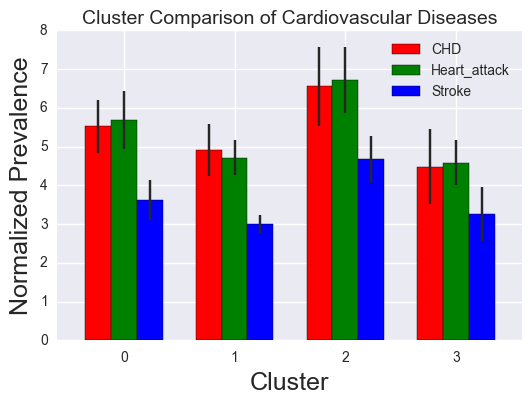

In [134]:
# Plotting prevalence of CVD by cluster
clusgrp_cvd_bar = clusgrp_cvd_mean.drop(clusgrp_cvd_mean.ix[:,'GDP_2012':'Smoking'].columns, 1)
clusgrp_cvd_bar = clusgrp_cvd_bar.drop('cluster', 1)
colors = ['r', 'g', 'b']
ax = clusgrp_cvd_bar.plot(kind='bar', figsize=(6, 4), legend=True, width = 0.7, fontsize=10, color=colors, yerr=clusgrp_cvd_std)
ax.set_title('Cluster Comparison of Cardiovascular Diseases', fontsize=14)
ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel("Normalized Prevalence", fontsize=18)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
plt.show()

The analysis shows that the affinity propagation clustering results are similar to those obtained by K-means clustering, and the RF profiles of estimated clusters are not significantly different. The difference between the two techniques is that predetermination of the number of clusters is not required for affinity propagation. In addition, the list of states estimated for each cluster by the affinity propagation model is the same for repetitive estimations.

The CVD profiles of the clusters shown in the above figure are in agreement with their RF profiles. This relationship can be described by the following paradigm observed in this study: the higher is the prevalence of traditional risk factors, the lower is the prevalence of CVD. At the same time, the relationship between states socioeconomic characteristics and CVD is more complex and is not linear. This conclusion is drawn from the comparison of the profiles of the West and North-East clusters. The values of socioeconomic characteristics are higher for the North-East cluster in comparison with the East cluster. However, the prevalence of CHD and stroke is lower for the West cluster. The prevalence of heart attack is lower for the North-East cluster, which is well explained by higher importance of socioeconomic factors in its prevalence.

Overall, the results of the cluster analysis are in a good agreement with those of the random forests model. The better performance of the random forests model in comparison with that of the linear regression model is explained by non-linear relationship between the prevalence of CVD and socioeconomic factors.

In the last step, statistical significance of the proposed clusters based on the prevalence of CVD will be estimated.

In [135]:
# Estimating statistical significance of the proposed clusters based on the prevalence of CHD using OLS method
chd_data = merged1_all[['CHD', 'cluster']].dropna()
chd_mod = smf.ols(formula='CHD ~ C(cluster)', data = chd_data).fit()
print(chd_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                    CHD   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     11.79
Date:                Sat, 11 Mar 2017   Prob (F-statistic):           7.46e-06
Time:                        12:01:07   Log-Likelihood:                -58.876
No. Observations:                  50   AIC:                             125.8
Df Residuals:                      46   BIC:                             133.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           5.5195      0.171     

In [136]:
# Estimating the difference in the prevalence of CHD between all clusters using Tukey's range test
mc_chd = multi.MultiComparison(chd_data['CHD'], chd_data['cluster'])
res2 = mc_chd.tukeyhsd()
print(res2.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.6132  -1.5555  0.3292 False 
  0      2     1.0357   0.2088  1.8626  True 
  0      3    -1.0362  -1.8631 -0.2093  True 
  1      2     1.6489   0.5731  2.7247  True 
  1      3     -0.423  -1.4988  0.6528 False 
  2      3    -2.0719  -3.0482 -1.0956  True 
---------------------------------------------


In [137]:
# Estimating statistical significance of the proposed clusters based on the prevalence of heart attack using OLS method
ha_data = merged1_all[['Heart_attack', 'cluster']].dropna()
ha_mod = smf.ols(formula='Heart_attack ~ C(cluster)', data = ha_data).fit()
print(ha_mod.summary())

                            OLS Regression Results                            
Dep. Variable:           Heart_attack   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     18.63
Date:                Sat, 11 Mar 2017   Prob (F-statistic):           4.71e-08
Time:                        12:01:07   Log-Likelihood:                -51.840
No. Observations:                  50   AIC:                             111.7
Df Residuals:                      46   BIC:                             119.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           5.6914      0.148     

In [138]:
# Estimating the difference in the prevalence of heart attack between all clusters using Tukey's range test
mc_ha = multi.MultiComparison(ha_data['Heart_attack'], ha_data['cluster'])
res3 = mc_ha.tukeyhsd()
print(res3.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.9784   -1.797 -0.1597  True 
  0      2     1.0281   0.3097  1.7465  True 
  0      3    -1.1036   -1.822 -0.3852  True 
  1      2     2.0065   1.0719  2.9411  True 
  1      3    -0.1252  -1.0598  0.8094 False 
  2      3    -2.1317  -2.9798 -1.2835  True 
---------------------------------------------


In [139]:
# Estimating statistical significance of the proposed clusters based on the prevalence of stroke using OLS method
stroke_data = merged1_all[['Stroke', 'cluster']].dropna()
stroke_mod = smf.ols(formula='Stroke ~ C(cluster)', data = stroke_data).fit()
print(stroke_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 Stroke   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     16.53
Date:                Sat, 11 Mar 2017   Prob (F-statistic):           1.99e-07
Time:                        12:01:08   Log-Likelihood:                -38.920
No. Observations:                  50   AIC:                             85.84
Df Residuals:                      46   BIC:                             93.49
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           3.6263      0.115     

In [140]:
# Estimating the difference in the prevalence of stroke between all clusters using Tukey's range test
mc_stroke = multi.MultiComparison(stroke_data['Stroke'], stroke_data['cluster'])
res4 = mc_stroke.tukeyhsd()
print(res4.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.6262  -1.2584  0.0061 False 
  0      2     1.0474   0.4926  1.6022  True 
  0      3    -0.3702   -0.925  0.1845 False 
  1      2     1.6735   0.9518  2.3953  True 
  1      3     0.2559  -0.4659  0.9777 False 
  2      3    -1.4176  -2.0726 -0.7626  True 
---------------------------------------------


The analysis shows that not all differences in the prevalence of CVD between clusters are statistically significant. This also depends on the type of CVD. This result underlines the limitation of the current study, which operates with the mean values of prevalence of CVD in different demographic groups for each state. In addition, small sample size, which is equal to the number of states in the cluster, contributes to the statistical insignificance.

## Conclusion / Client Recommendations

The findings of this study are in agreement with prevoiusly reported observations concluding that the prevalence of CVD is strongly correlated with that of traditional risk factors, increases with advancing age and varies within racial, ethnic, and sociodemographic groups. 

The analysis and predictive modelling conducted in this study can be of interest to U.S. federal and state health agencies. The analysis showed that the prevalence of CVD is not dependent on the level of healthcare spending, which implies that the healthcare system is not effective in preventing CVD. The proposed models predict that overall increase in healthcare spending will not decrease the prevalence of CVD. Instead, funding of campaigns aimed at increasing public knowledge and awareness of CVD and associated risk factors as well as at promoting healthy lifestyle should be increased. Considering the projection that only annual direct medical costs associated with CVD will rise to more than 818 billion dollars by 2030, even 1% decrease (from 6% to 5%) in the prevalence of CVD would substantially reduce (by hundreds of billion dollars) the burden on the healthcare system.

Health authorities in such states as South Dakota, Maine, Ohio, Missuori, Michigan, Iowa, and Oklahoma should be aware of the finding that a decrease in the socioeconomic level of these states and increase in the prevalence of RF will put a higher burden on their budgets in comparison to other states.

The present findings can also be of interest to insurance companies. Taken into account that premium rates for policyholders are calculated with the help of risk assessment, correct assessment based on the proposed models could save millions of dollars for insurance companies.